# **Financial transaction modelling and analysis to identify fraudulent transactions**

# Executive Summary
Many organizations, industries, and individuals experience fraud. This notebook attempts to develop a model that can predict fraudulent transactions. In order to accomplish this, a number of libraries are employed (sweetviz, pandas, numpy, Matplotlib, Seaborn, SMOTE, sklearn amongst others). The individual models are reviewed based on their pros and cons, and the best solution (XGBoost) is chosen at this point. The model should, however, be tested using real data, and in future work it should be replicated using fewer features. 

# Package installation

In [ ]:
!pip install pandas
!pip install numpy
!pip install tabula-py
!pip install sweetviz
# imbalanced-learn library used for SMOTE
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import tabula as tab
import matplotlib.pyplot as plt
import sweetviz as sv
import statistics
import imblearn

from numpy import where

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where

#Splitting libraries
from sklearn.model_selection import train_test_split
#logistic regression
from sklearn.linear_model import LogisticRegression
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# Random tree classifier
from sklearn.ensemble import RandomForestClassifier
#Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier
# XGBoost algorithm
from xgboost import XGBClassifier

# to evaluate the model accuracy
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, classification_report, roc_curve, auc
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import mean_squared_error


from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import pydotplus

# support neural network models
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from pandas_profiling import ProfileReport
from IPython import display
from ipywidgets import interact, widgets

%matplotlib inline

# Importing, cleaning and preparing the data

**Importing and checking** 

In [ ]:
# reading a csv file using pandas
df = pd.read_csv('/content/CreditCardDataFinal.csv')

In [ ]:
#helps to understand the volume of data being handled
def dflength():
  print('Number of rows in the dataframe is ', len(df))

def dfcol():
  print('Number of columns in the dataframe is', len(df.columns))

In [ ]:
dflength()
dfcol()

Number of rows in the dataframe is  100000
Number of columns in the dataframe is 16


In [ ]:
# sample 5 rows and columns
df.head()

Transaction ID       Date Day of Week  Time Type of Card Entry Mode Amount  \
0      #3577 209  14-Oct-20   Wednesday    19         Visa        Tap     £5   
1      #3039 221  14-Oct-20   Wednesday    17   MasterCard        PIN   £288   
2      #2694 780  14-Oct-20   Wednesday    14         Visa        Tap     £5   
3      #2640 960  13-Oct-20     Tuesday    14         Visa        Tap    £28   
4      #2771 031  13-Oct-20     Tuesday    23         Visa        CVC    £91   

  Type of Transaction Merchant Group Country of Transaction Shipping Address  \
0                 POS  Entertainment         United Kingdom   United Kingdom   
1                 POS       Services                    USA              USA   
2                 POS     Restaurant                  India            India   
3                 POS  Entertainment         United Kingdom            India   
4              Online    Electronics                    USA              USA   

  Country of Residence Gender   Age      Bank  Fraud  
0       United Kingdom      M  25.2       RBS      0  
1                  USA      F  49.6    Lloyds      0  
2                India      F  42.2  Barclays      0  
3       United Kingdom      F  51.0  Barclays      0  
4       United Kingdom      M  38.0   Halifax      1

In [ ]:
# exploring df columns and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Transaction ID          100000 non-null  object 
 1   Date                    100000 non-null  object 
 2   Day of Week             100000 non-null  object 
 3   Time                    100000 non-null  int64  
 4   Type of Card            100000 non-null  object 
 5   Entry Mode              100000 non-null  object 
 6   Amount                  99994 non-null   object 
 7   Type of Transaction     100000 non-null  object 
 8   Merchant Group          99990 non-null   object 
 9   Country of Transaction  100000 non-null  object 
 10  Shipping Address        99995 non-null   object 
 11  Country of Residence    100000 non-null  object 
 12  Gender                  99996 non-null   object 
 13  Age                     100000 non-null  float64
 14  Bank                 

##Preparing and Cleaning

In [ ]:
#checking for blanks
df.isnull().sum()

Transaction ID             0
Date                       0
Day of Week                0
Time                       0
Type of Card               0
Entry Mode                 0
Amount                     6
Type of Transaction        0
Merchant Group            10
Country of Transaction     0
Shipping Address           5
Country of Residence       0
Gender                     4
Age                        0
Bank                       0
Fraud                      0
dtype: int64

* 6 *Amounts*. Is this a marker of a transaction check, i.e. checking card is working?
* 10 *Merchant Groups*. Issues with the database configuration (source of the excel) or process issue?
* 5 *Shipping Addresses*. How could trasactions be complete? Is it online or subscription transactions?  
* 4 *Gender*. Low volume = limited impact? Gender has higher implications, due to it being a protected characteristic (GOV.UK, 2013). 

In [ ]:
#Review the rows with missing df
def missingrows():
  blanksdf=df[df.isnull().any(axis=1)]
  print(blanksdf)
  print("The data where some blanks exist contains ", len(blanksdf), "rows")

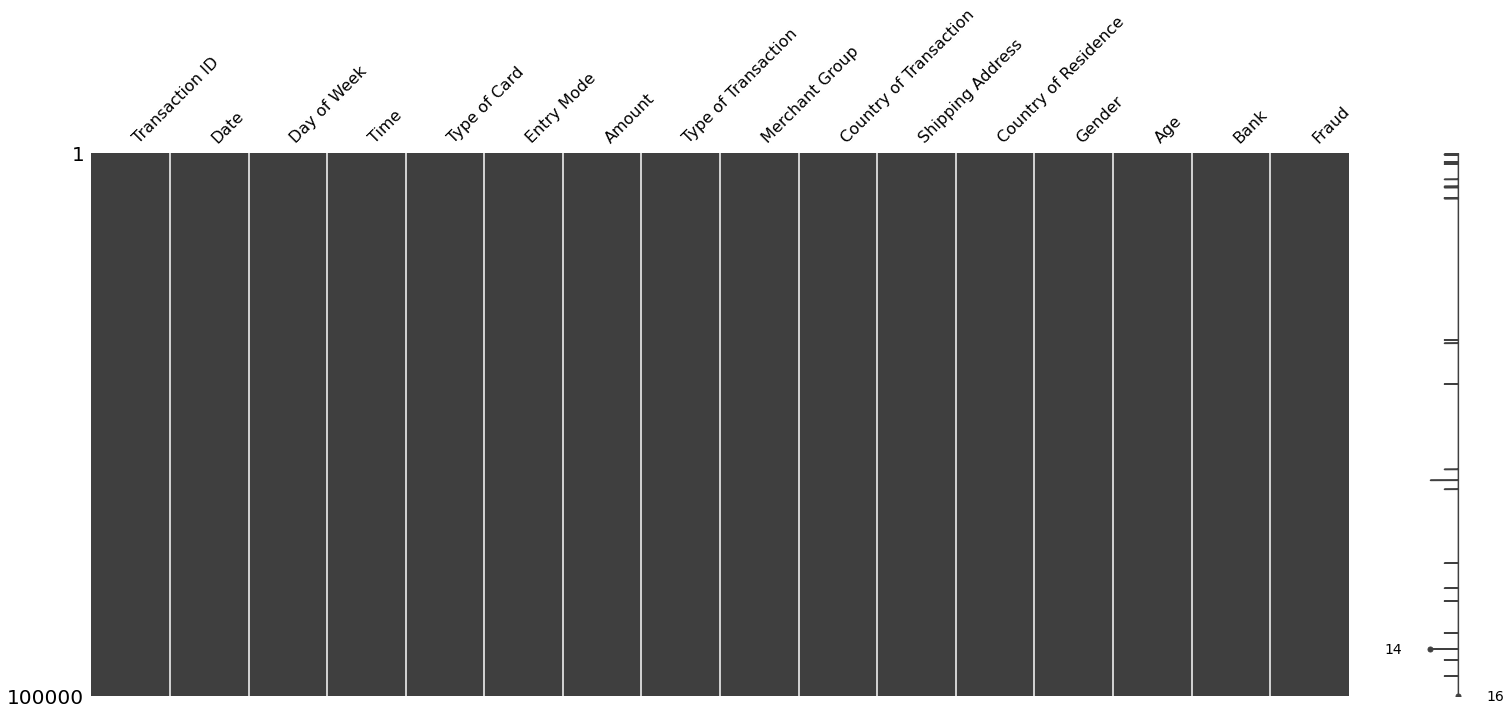

In [ ]:
# visualising missing values
import missingno as msno
msno.matrix(df)

In [ ]:
missingrows()

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
286        #2550 151  13-Oct-20     Tuesday    13         Visa        PIN   
383        #2550 715  14-Oct-20   Wednesday    15         Visa        PIN   
1720       #2550 654  14-Oct-20   Wednesday    10         Visa        PIN   
2092       #2550 150  14-Oct-20   Wednesday    21         Visa        CVC   
4913       #2550 516  14-Oct-20   Wednesday    20   MasterCard        CVC   
6208       #2550 472  14-Oct-20   Wednesday    17   MasterCard        PIN   
6404       #2550 074  14-Oct-20   Wednesday    21   MasterCard        PIN   
8299       #2550 517  14-Oct-20   Wednesday    17   MasterCard        CVC   
8436       #2550 479  13-Oct-20     Tuesday     9   MasterCard        PIN   
34456      #2550 256  13-Oct-20     Tuesday     1   MasterCard        CVC   
35068      #2550 306  14-Oct-20   Wednesday    11         Visa        Tap   
42573      #2550 489  14-Oct-20   Wednesday    15   MasterCard        Tap   

Our data set contains 100,000 rows, compared to 23 rows where some data is blank, due to volume they are dropped. 

In [ ]:
#dropping rows with null values
df=df.dropna()

In [ ]:
#double checking
missingrows()
dflength()
dfcol()

Empty DataFrame
Columns: [Transaction ID, Date, Day of Week, Time, Type of Card, Entry Mode, Amount, Type of Transaction, Merchant Group, Country of Transaction, Shipping Address, Country of Residence, Gender, Age, Bank, Fraud]
Index: []
The data where some blanks exist contains  0 rows
Number of rows in the dataframe is  99977
Number of columns in the dataframe is 16


In [ ]:
# Listing only duplicated values based on columns
df_duplicates = df[df.duplicated (subset = None, keep = False)]
print (df_duplicates)

Empty DataFrame
Columns: [Transaction ID, Date, Day of Week, Time, Type of Card, Entry Mode, Amount, Type of Transaction, Merchant Group, Country of Transaction, Shipping Address, Country of Residence, Gender, Age, Bank, Fraud]
Index: []


`Empty DataFrame` = no "true duplicates" in the dataframe, i.e. where all the values are exactly the same. 

In [ ]:
#checking unique values in individual columns
def uniquevalues():
  for col in df:
    unique=df[col].unique()
    print(sorted(unique))

In [ ]:
uniquevalues()

['#2546 884', '#2546 895', '#2546 903', '#2546 906', '#2546 920', '#2546 921', '#2546 932', '#2546 934', '#2546 935', '#2546 936', '#2546 949', '#2546 951', '#2546 963', '#2546 965', '#2547 017', '#2547 098', '#2547 109', '#2547 130', '#2547 136', '#2547 161', '#2547 171', '#2547 198', '#2547 215', '#2547 219', '#2547 222', '#2547 228', '#2547 251', '#2547 255', '#2547 258', '#2547 292', '#2547 293', '#2547 298', '#2547 321', '#2547 332', '#2547 333', '#2547 340', '#2547 343', '#2547 379', '#2547 395', '#2547 399', '#2547 404', '#2547 420', '#2547 427', '#2547 428', '#2547 434', '#2547 436', '#2547 464', '#2547 466', '#2547 478', '#2547 480', '#2547 512', '#2547 564', '#2547 593', '#2547 595', '#2547 600', '#2547 604', '#2547 612', '#2547 625', '#2547 629', '#2547 636', '#2547 641', '#2547 652', '#2547 725', '#2547 727', '#2547 746', '#2547 762', '#2547 768', '#2547 792', '#2547 795', '#2547 800', '#2547 801', '#2547 806', '#2547 817', '#2547 819', '#2547 820', '#2547 863', '#2547 865'

In [ ]:
# Checking Transaction ID (as per in sweetviz)
def duplicates():
  transactionIDduplicate = df[df.duplicated('Transaction ID')]
  print(transactionIDduplicate)
  print(len(transactionIDduplicate), 'rows have a duplicated Transaction ID')
  print('Size of duplicates in the dataframe is ', round((len(transactionIDduplicate)/len(df)*100)), '%')

In [ ]:
duplicates()

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
1516       #3003 533  14-Oct-20   Wednesday    20         Visa        CVC   
1978       #3512 597  14-Oct-20   Wednesday     8         Visa        CVC   
3034       #3522 589  13-Oct-20     Tuesday    10   MasterCard        PIN   
3293       #3322 751  14-Oct-20   Wednesday     7   MasterCard        PIN   
3317       #2862 486  14-Oct-20   Wednesday    20   MasterCard        PIN   
...              ...        ...         ...   ...          ...        ...   
99927      #3045 680  13-Oct-20     Tuesday    17         Visa        PIN   
99955      #3095 445  13-Oct-20     Tuesday    22         Visa        PIN   
99972      #2729 389  13-Oct-20     Tuesday    17   MasterCard        PIN   
99989      #3056 730  14-Oct-20   Wednesday    14   MasterCard        Tap   
99999      #3400 711  14-Oct-20   Wednesday    16         Visa        PIN   

      Amount Type of Transaction Merchant Group Country of Transaction  \
1

Duplication in Transaction ID (first discovered in sweetviz) is concerning, since `Transaction ID` = unique identifier. Check the source and determine if it is a human error, or ID's are associated with different banks. 

4% of duplicates are not "true duplicates", they will be retained. But credibility of the dataset is questioned. 

In [ ]:
# checking for max values in df to spot any issues/clear outliers
df.max()

Transaction ID                 #3687 455
Date                           16-Oct-20
Day of Week                    Wednesday
Time                                  24
Type of Card                        Visa
Entry Mode                           Tap
Amount                               £99
Type of Transaction                  POS
Merchant Group              Subscription
Country of Transaction    United Kingdom
Shipping Address          United Kingdom
Country of Residence      United Kingdom
Gender                                 M
Age                                 86.1
Bank                                 RBS
Fraud                                  1
dtype: object

In [ ]:
# checking min values, particularly for age
df.min()

Transaction ID             #2546 884
Date                       13-Oct-20
Day of Week                   Friday
Time                               0
Type of Card              MasterCard
Entry Mode                       CVC
Amount                           £10
Type of Transaction              ATM
Merchant Group              Children
Country of Transaction         China
Shipping Address               China
Country of Residence           China
Gender                             F
Age                             15.0
Bank                        Barclays
Fraud                              0
dtype: object

Out of project scope
* 16-Oct-2020 - drop
* Time 24. 24 = 00 - replace
* Friday - drop

In [ ]:
#sorting out unique time columns
def uniquetime():
  uniqtime = df.Time.unique()
  print('Unique Time values in the dataframe', sorted(uniqtime))

In [ ]:
uniquetime()

Unique Time values in the dataframe [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [ ]:
#filter where Time equals to 24
df[df['Time'] ==24]

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
32446      #2547 017  14-Oct-20   Wednesday    24   MasterCard        CVC   

      Amount Type of Transaction Merchant Group Country of Transaction  \
32446   £371              Online    Electronics                  India   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  
32446            India                India      M  57.7  Barclays      1

In [ ]:
#24th hour is == 00 of the next day; given that hour data set is looking at 13-14th of October this data line will be removed
df.drop(df.loc[df['Time']==24].index, inplace=True)

In [ ]:
#double-checking
df[df['Time'] ==24]

Empty DataFrame
Columns: [Transaction ID, Date, Day of Week, Time, Type of Card, Entry Mode, Amount, Type of Transaction, Merchant Group, Country of Transaction, Shipping Address, Country of Residence, Gender, Age, Bank, Fraud]
Index: []

In [ ]:
# Values by date
def datevalues():
  print(df.groupby(['Date']).count())

In [ ]:
datevalues()

           Transaction ID  Day of Week   Time  Type of Card  Entry Mode  \
Date                                                                      
13-Oct-20           49802        49802  49802         49802       49802   
14-Oct-20           50172        50172  50172         50172       50172   
15-Oct-20               1            1      1             1           1   
16-Oct-20               1            1      1             1           1   

           Amount  Type of Transaction  Merchant Group  \
Date                                                     
13-Oct-20   49802                49802           49802   
14-Oct-20   50172                50172           50172   
15-Oct-20       1                    1               1   
16-Oct-20       1                    1               1   

           Country of Transaction  Shipping Address  Country of Residence  \
Date                                                                        
13-Oct-20                   49802             

In [ ]:
# dropping 15 & 16 - Oct date values 
df.drop(df.loc[df['Date']=='15-Oct-20'].index, inplace=True)
df.drop(df.loc[df['Date']=='16-Oct-20'].index, inplace=True)

In [ ]:
def Weekday():
  uniqueday = df['Day of Week'].unique()
  DayofWeek = df.groupby(['Day of Week']).count()
  print( DayofWeek)
  print ('A count of rows within the individual Days of Week in the dataframe is listed above')
  print('Unique Days of Week in dataframe are ', uniqueday)

In [ ]:
Weekday()

             Transaction ID   Date   Time  Type of Card  Entry Mode  Amount  \
Day of Week                                                                   
Friday                   13     13     13            13          13      13   
Thursday                 11     11     11            11          11      11   
Tuesday               49785  49785  49785         49785       49785   49785   
Wednesday             50165  50165  50165         50165       50165   50165   

             Type of Transaction  Merchant Group  Country of Transaction  \
Day of Week                                                                
Friday                        13              13                      13   
Thursday                      11              11                      11   
Tuesday                    49785           49785                   49785   
Wednesday                  50165           50165                   50165   

             Shipping Address  Country of Residence  Gender    Age  

In [ ]:
# filtering and listing the data for Thursday and Friday
def OutofScopeDays():
  Thursday = df[df['Day of Week'] =='Thursday']
  Friday = df[df['Day of Week'] =='Friday']
  print(Thursday)
  print(Friday)

In [ ]:
OutofScopeDays()

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
904        #3314 299  14-Oct-20    Thursday     7   MasterCard        Tap   
1731       #3522 079  13-Oct-20    Thursday    12   MasterCard        PIN   
2237       #2562 403  13-Oct-20    Thursday    19         Visa        PIN   
10483      #2982 416  13-Oct-20    Thursday     7         Visa        PIN   
20296      #3066 613  13-Oct-20    Thursday    10         Visa        PIN   
37546      #2870 052  13-Oct-20    Thursday    13   MasterCard        Tap   
64778      #3328 717  14-Oct-20    Thursday    16   MasterCard        Tap   
75994      #3271 352  13-Oct-20    Thursday    16         Visa        Tap   
85161      #2674 437  13-Oct-20    Thursday    18   MasterCard        PIN   
86048      #3290 748  13-Oct-20    Thursday     9         Visa        Tap   
99871      #3623 408  13-Oct-20    Thursday     9   MasterCard        PIN   

      Amount Type of Transaction Merchant Group Country of Transaction  \
9

Day of the Week is stated as Thursday or Friday, the dates are correct (within scope). Again the validity of the data is in question. `Date` or `Day of Week` that are recorded incorrectly? 
Due to low volume values (Thursday & Friday) are dropped. 

In [ ]:
# dropping Thursday and Friday values - out of scope
df.drop(df.loc[df['Day of Week']=='Thursday'].index, inplace=True)
df.drop(df.loc[df['Day of Week']=='Friday'].index, inplace=True)

In [ ]:
#double checking
OutofScopeDays()

Empty DataFrame
Columns: [Transaction ID, Date, Day of Week, Time, Type of Card, Entry Mode, Amount, Type of Transaction, Merchant Group, Country of Transaction, Shipping Address, Country of Residence, Gender, Age, Bank, Fraud]
Index: []
Empty DataFrame
Columns: [Transaction ID, Date, Day of Week, Time, Type of Card, Entry Mode, Amount, Type of Transaction, Merchant Group, Country of Transaction, Shipping Address, Country of Residence, Gender, Age, Bank, Fraud]
Index: []


In [ ]:
# replacing misspelt values and making it a permanent change (identified via SweetViz)
df['Bank']=df['Bank'].str.replace('Barlcays','Barclays')

In [ ]:
# dropping £ currency sign & converting to a number following drop
df['Amount']= df['Amount'].str.replace('£','')
df[["Amount"]] = df[["Amount"]].apply(pd.to_numeric)

In [ ]:
# Verifying the changes
df.head()

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount  \
0      #3577 209  14-Oct-20   Wednesday    19         Visa        Tap       5   
1      #3039 221  14-Oct-20   Wednesday    17   MasterCard        PIN     288   
2      #2694 780  14-Oct-20   Wednesday    14         Visa        Tap       5   
3      #2640 960  13-Oct-20     Tuesday    14         Visa        Tap      28   
4      #2771 031  13-Oct-20     Tuesday    23         Visa        CVC      91   

  Type of Transaction Merchant Group Country of Transaction Shipping Address  \
0                 POS  Entertainment         United Kingdom   United Kingdom   
1                 POS       Services                    USA              USA   
2                 POS     Restaurant                  India            India   
3                 POS  Entertainment         United Kingdom            India   
4              Online    Electronics                    USA              USA   

  Country of Residence Gender   Age      Bank  Fraud  
0       United Kingdom      M  25.2       RBS      0  
1                  USA      F  49.6    Lloyds      0  
2                India      F  42.2  Barclays      0  
3       United Kingdom      F  51.0  Barclays      0  
4       United Kingdom      M  38.0   Halifax      1

In [ ]:
uniquevalues()

['#2546 884', '#2546 895', '#2546 903', '#2546 906', '#2546 920', '#2546 921', '#2546 932', '#2546 934', '#2546 935', '#2546 936', '#2546 949', '#2546 951', '#2546 963', '#2546 965', '#2547 017', '#2547 098', '#2547 109', '#2547 130', '#2547 136', '#2547 161', '#2547 171', '#2547 198', '#2547 215', '#2547 219', '#2547 222', '#2547 228', '#2547 251', '#2547 255', '#2547 258', '#2547 292', '#2547 293', '#2547 298', '#2547 321', '#2547 332', '#2547 333', '#2547 340', '#2547 343', '#2547 379', '#2547 395', '#2547 399', '#2547 404', '#2547 420', '#2547 427', '#2547 428', '#2547 434', '#2547 436', '#2547 464', '#2547 466', '#2547 478', '#2547 480', '#2547 512', '#2547 564', '#2547 593', '#2547 595', '#2547 600', '#2547 604', '#2547 612', '#2547 625', '#2547 629', '#2547 636', '#2547 641', '#2547 652', '#2547 725', '#2547 727', '#2547 746', '#2547 762', '#2547 768', '#2547 792', '#2547 795', '#2547 800', '#2547 801', '#2547 806', '#2547 817', '#2547 819', '#2547 820', '#2547 863', '#2547 865'

* Credibility of the data to be further investigated, i.e. Time & Date of the Week discrepencies, duplicated Transaction ID's, types of transactions (ATM) associated with Merchant Groups. 


-- When validity is questioned investigate the source platform!


# EDA and Visualisations

### EDA

                                             |          | [  0%]   00:00 -> (? left)


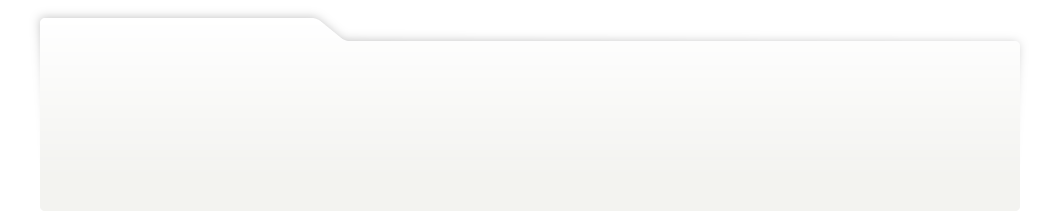
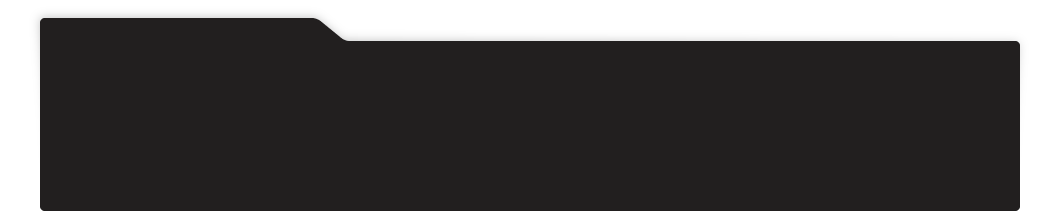
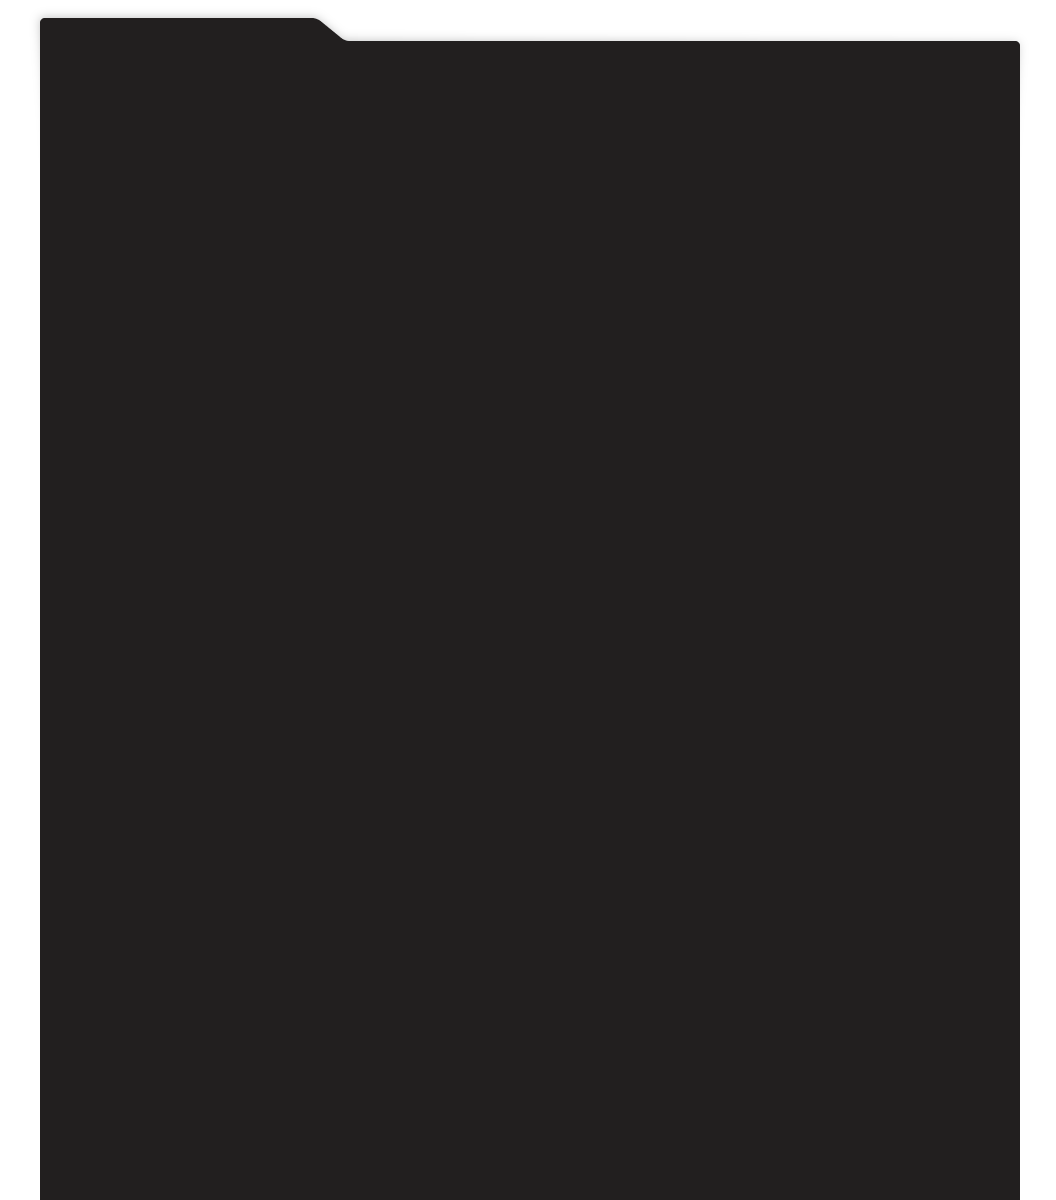
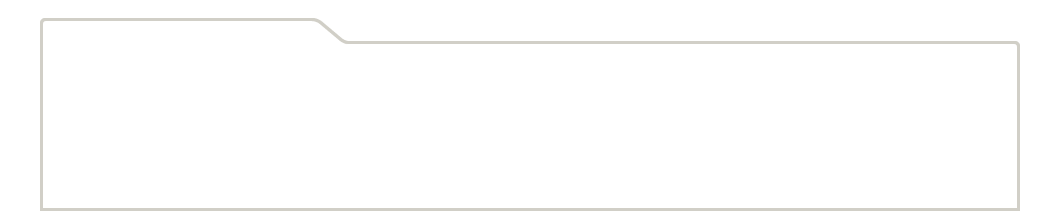
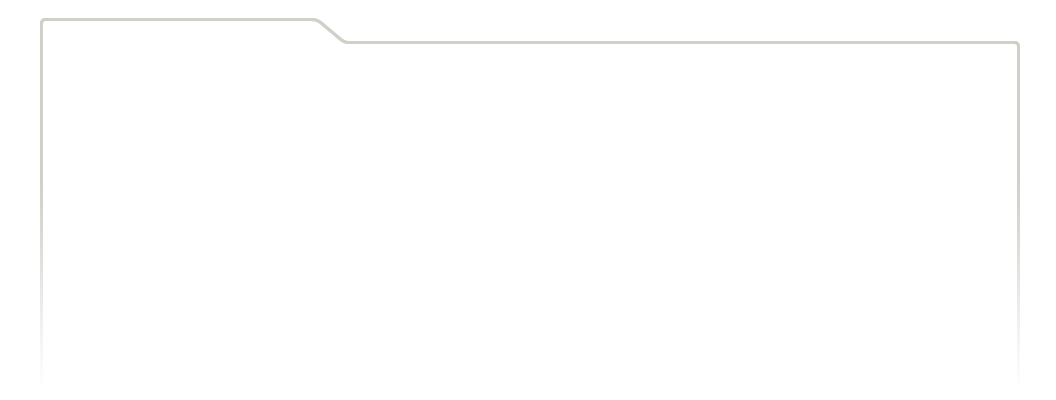
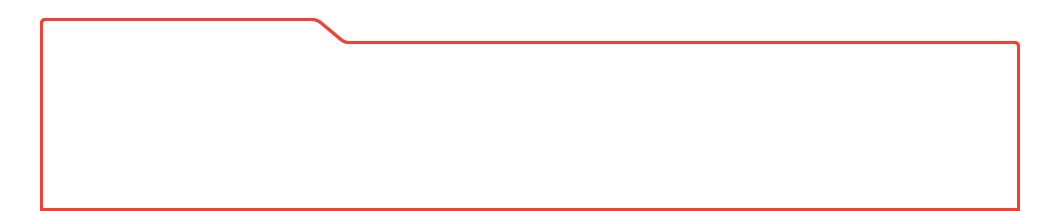
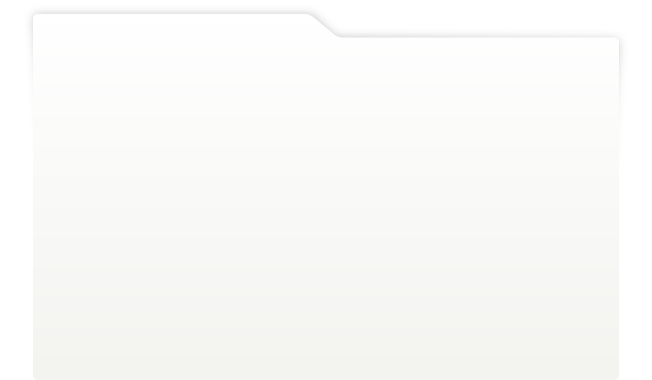
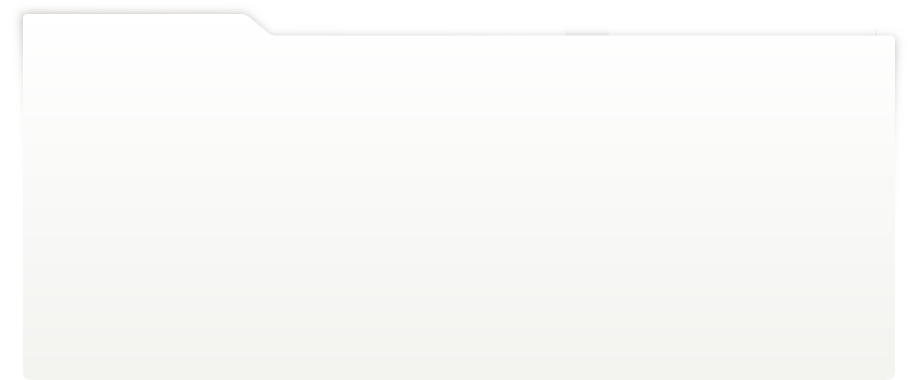
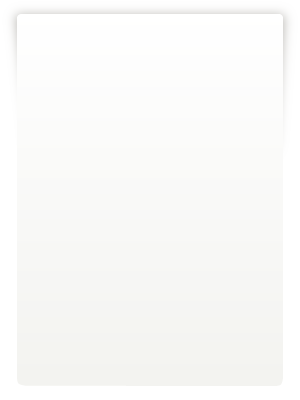
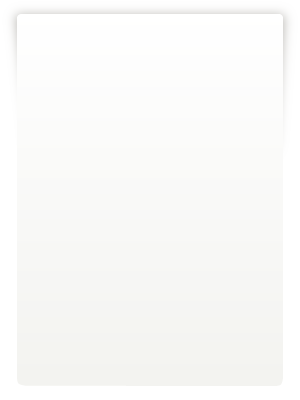
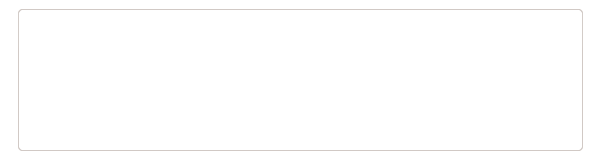
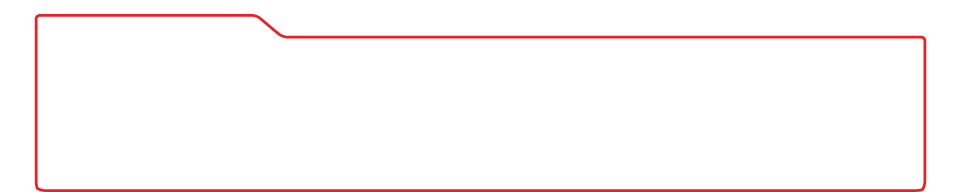
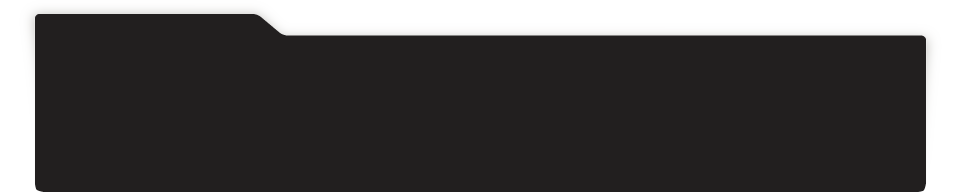
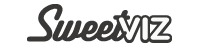
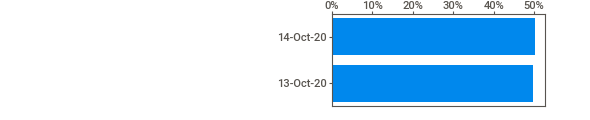
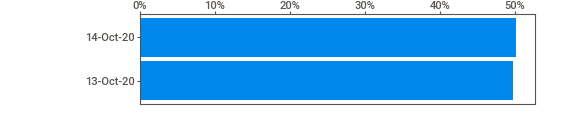
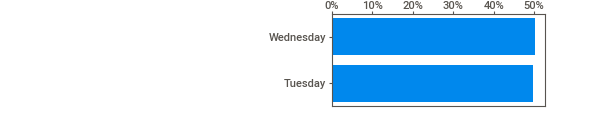
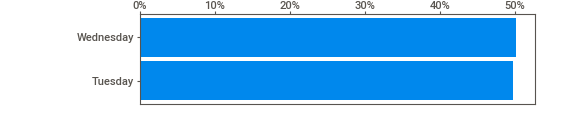
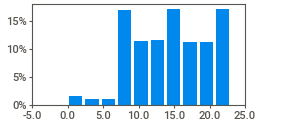
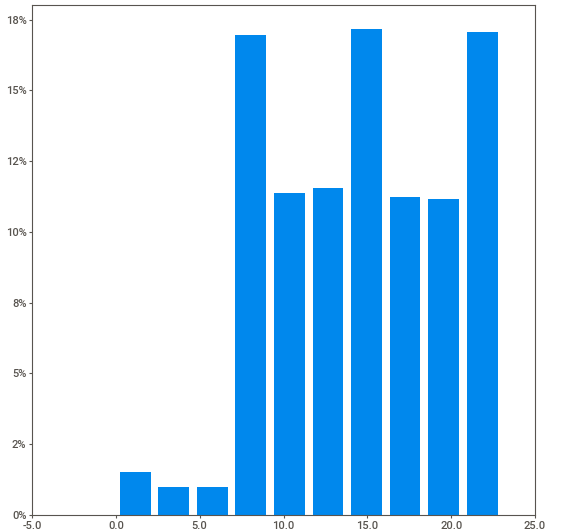
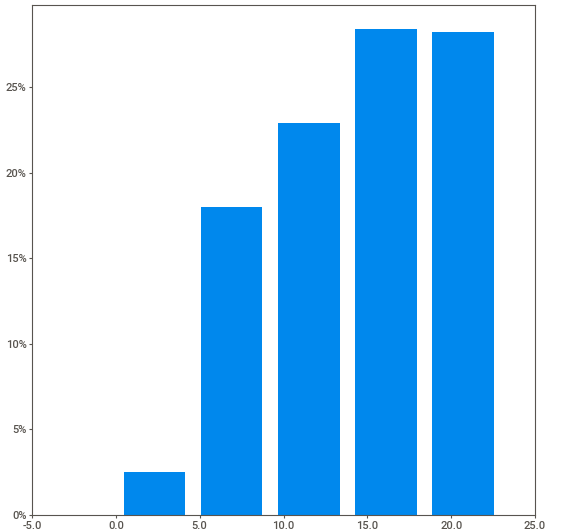
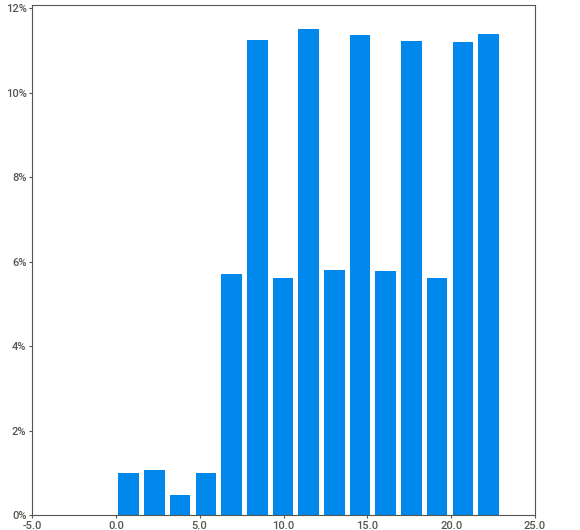
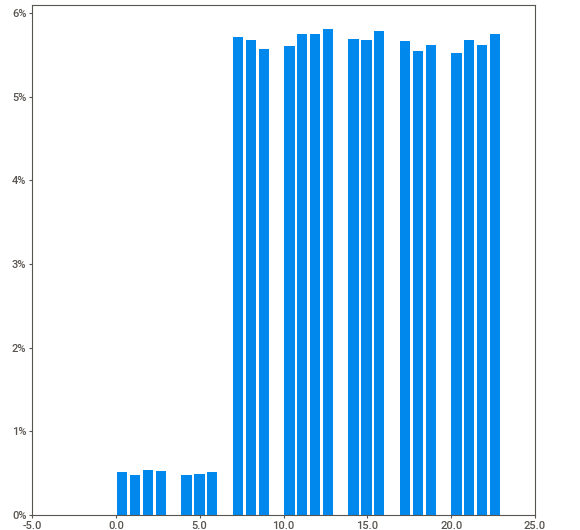
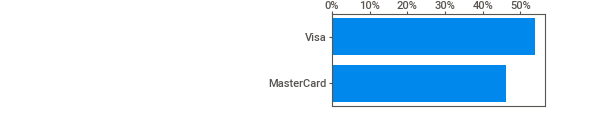
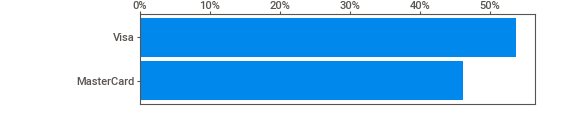
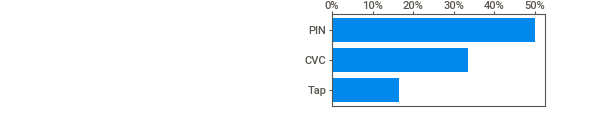
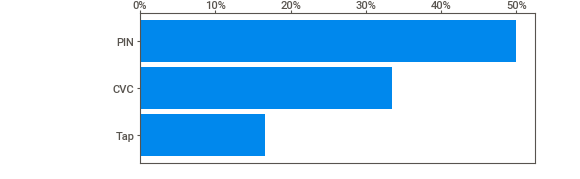
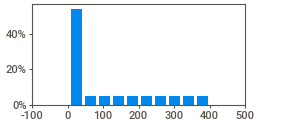
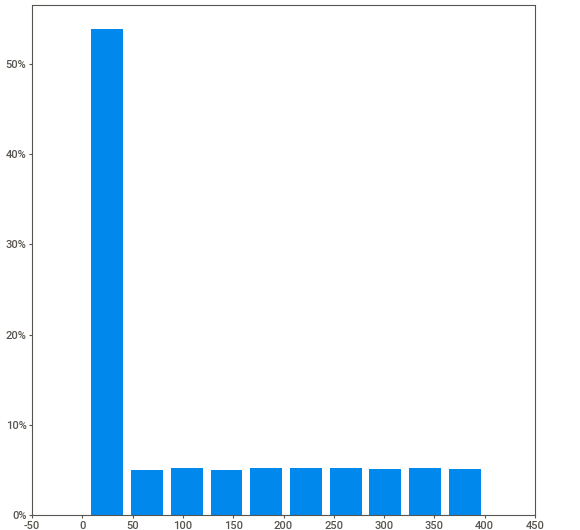
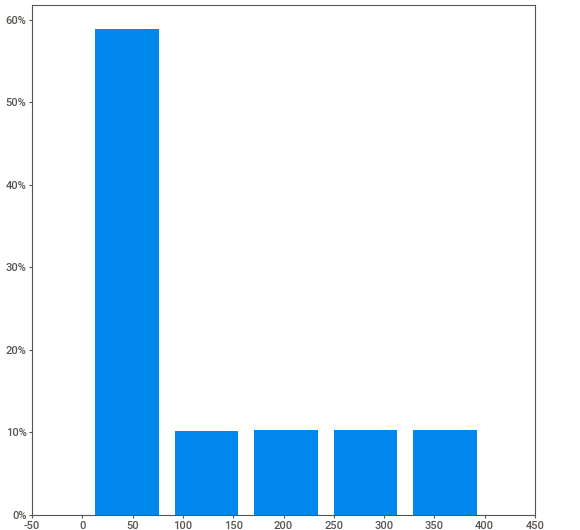
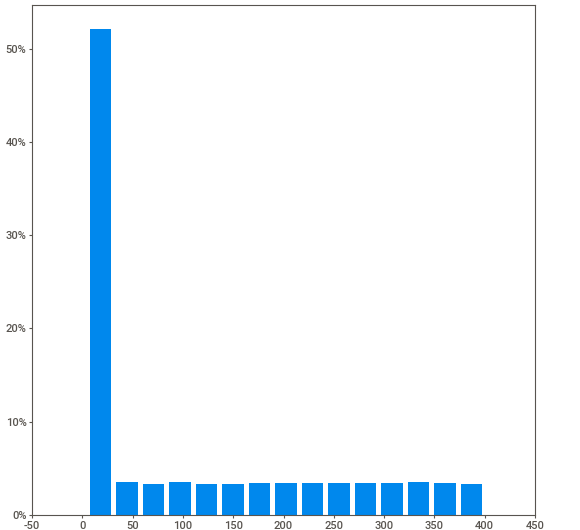
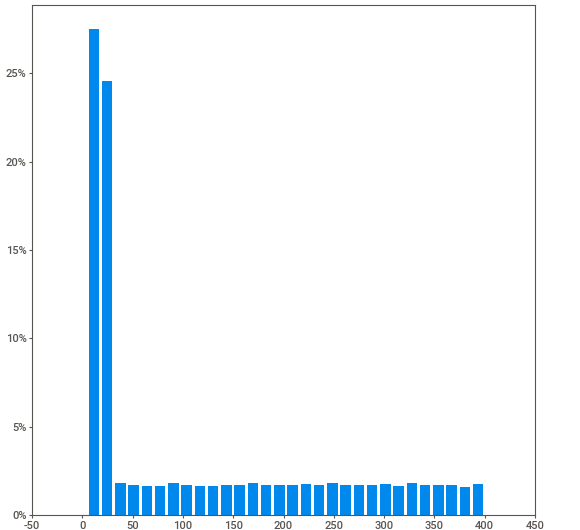
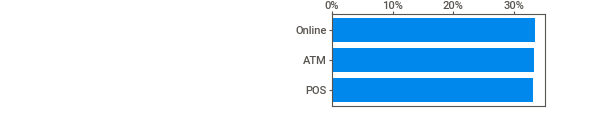
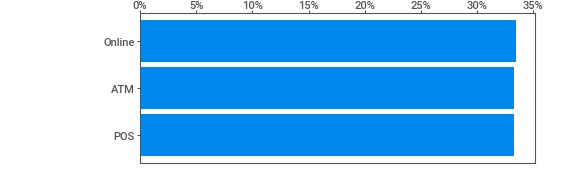
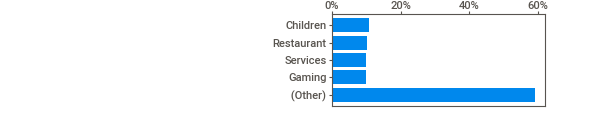
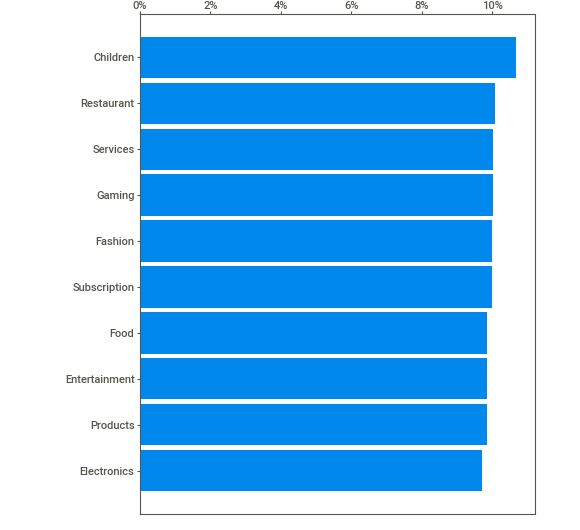
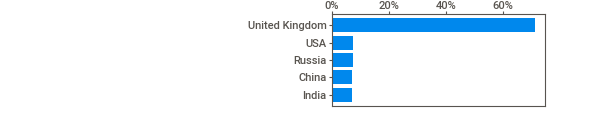
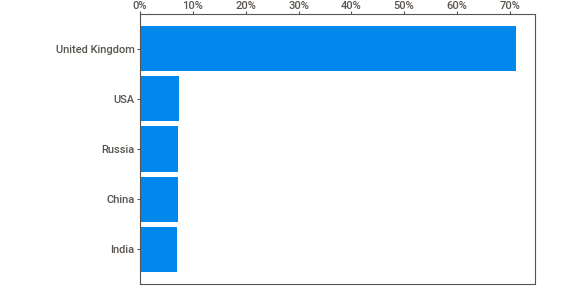
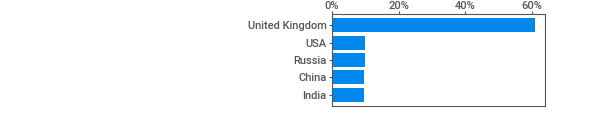
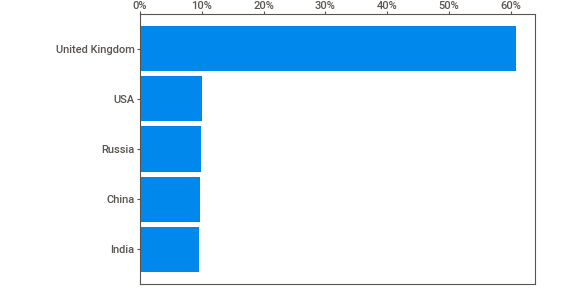
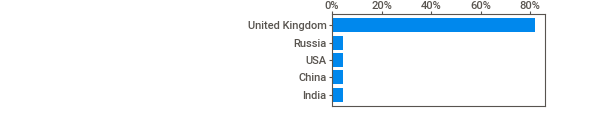
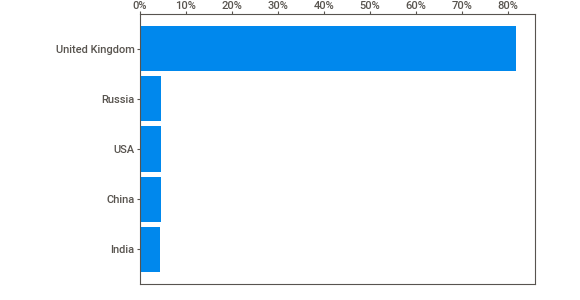
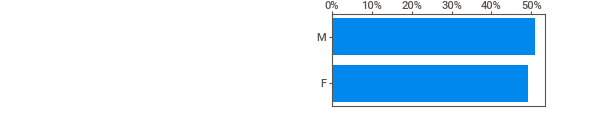
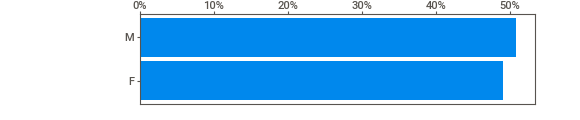
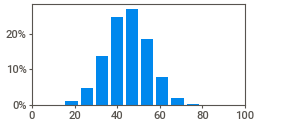
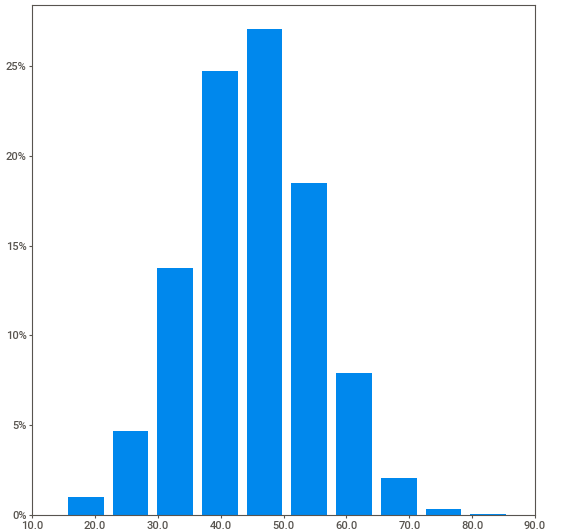
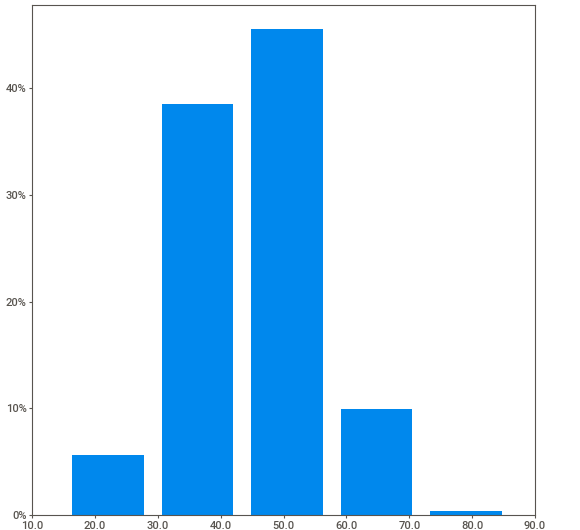
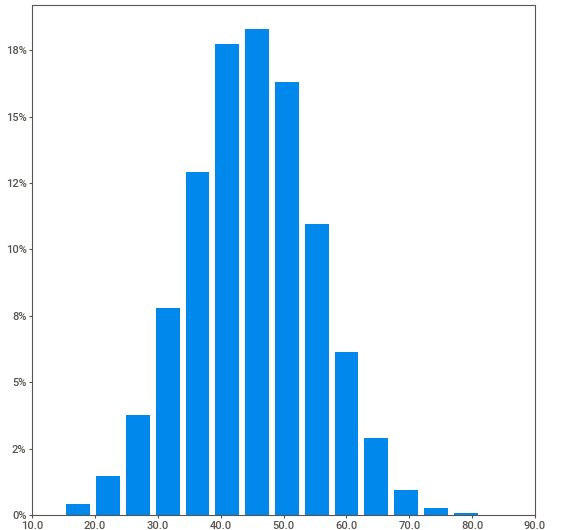
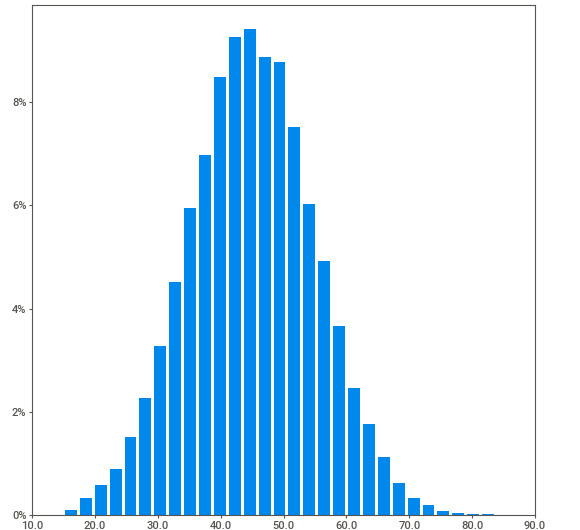
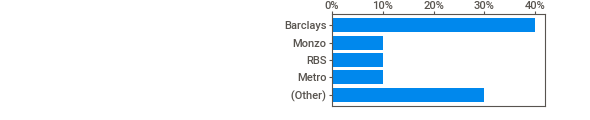
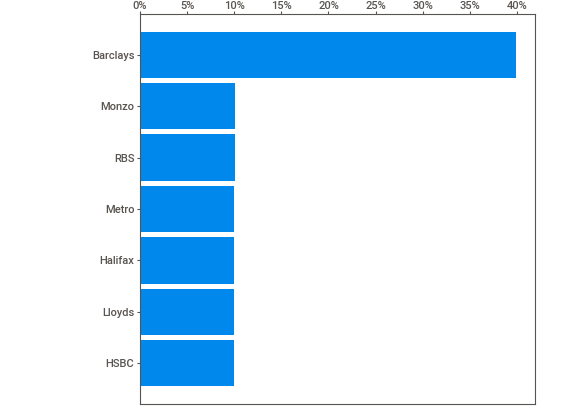
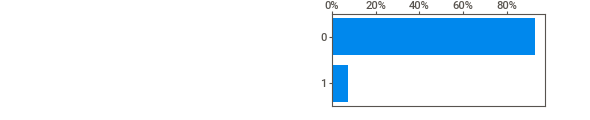
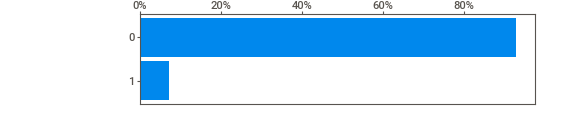
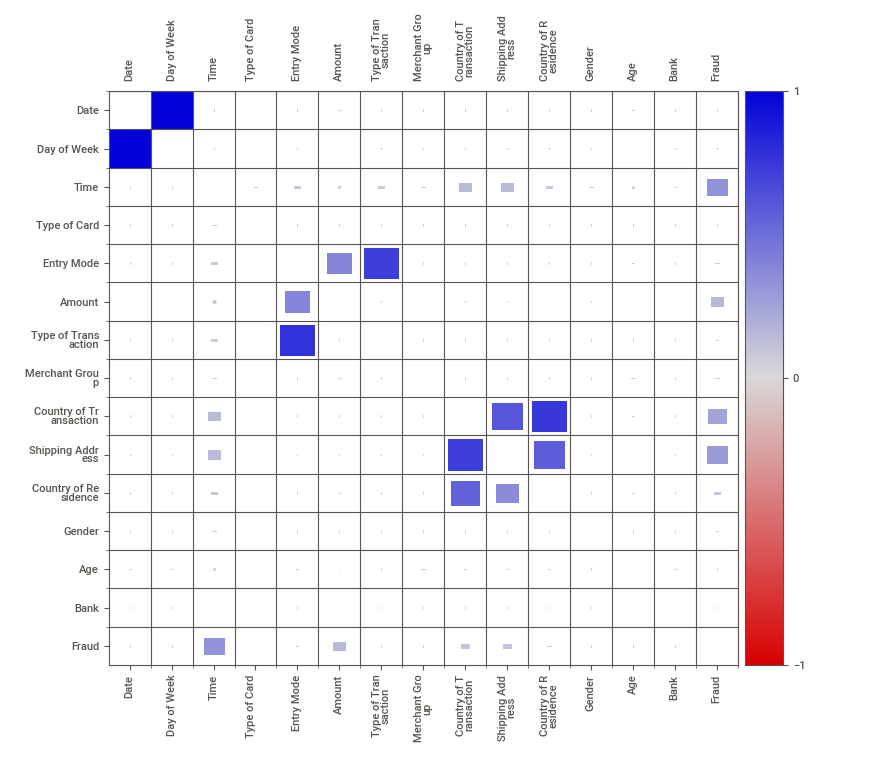
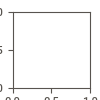

In [ ]:
# exploring/profiling df using sweetviz summary of df
Report = sv.analyze(df)
Report.show_notebook()

In [ ]:
def total_fraud():
  fraudcases = len(df[df['Fraud']==1])
  nonfraud = len(df[df['Fraud']==0])
  percentagefrautononfraud = round((fraudcases/nonfraud)*100)
  print('Ratio of Fraud vs non Fraud transactions is', percentagefrautononfraud,'%')

In [ ]:
total_fraud()

Ratio of Fraud vs non Fraud transactions is 8 %


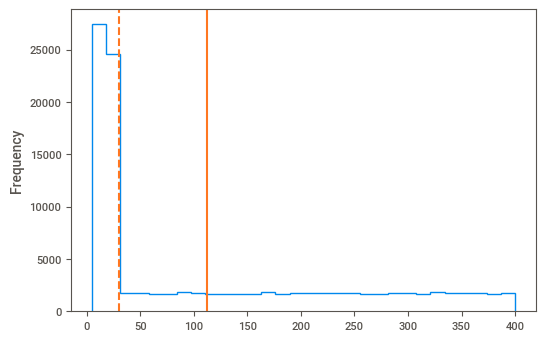

In [ ]:
# visualising amount distribution; SweetViz confirms
df.Amount.plot(kind='hist',histtype='step',bins=30)

plt.axvline(df.Amount.mean(),c='C1')
plt.axvline(df.Amount.median(),c='C1',linestyle='--')

Age Mean:44.994072
Age Median:44.900000


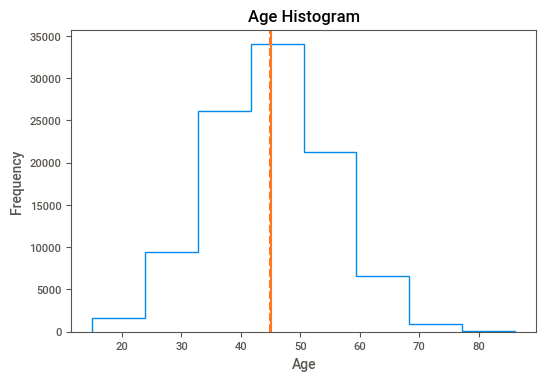

In [ ]:
#age distribution visual
df.Age.plot(kind='hist',histtype='step',bins=8)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Histogram')
plt.axvline(df.Age.mean(),c='C1')
plt.axvline(df.Age.median(),c='C1',linestyle='--')

print(f'Age Mean:{df.Age.mean():5f}')
print(f'Age Median:{df.Age.median():5f}')

In [ ]:
#creating bins for age groups
df['agegroup'] = pd.cut(df.Age,[0,19,29,39,49,59,69,79,89], labels=['0-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89'])
df.head()

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount  \
0      #3577 209  14-Oct-20   Wednesday    19         Visa        Tap       5   
1      #3039 221  14-Oct-20   Wednesday    17   MasterCard        PIN     288   
2      #2694 780  14-Oct-20   Wednesday    14         Visa        Tap       5   
3      #2640 960  13-Oct-20     Tuesday    14         Visa        Tap      28   
4      #2771 031  13-Oct-20     Tuesday    23         Visa        CVC      91   

  Type of Transaction Merchant Group Country of Transaction Shipping Address  \
0                 POS  Entertainment         United Kingdom   United Kingdom   
1                 POS       Services                    USA              USA   
2                 POS     Restaurant                  India            India   
3                 POS  Entertainment         United Kingdom            India   
4              Online    Electronics                    USA              USA   

  Country of Residence Gender   Age      Bank  Fraud agegroup  
0       United Kingdom      M  25.2       RBS      0    20-29  
1                  USA      F  49.6    Lloyds      0    50-59  
2                India      F  42.2  Barclays      0    40-49  
3       United Kingdom      F  51.0  Barclays      0    50-59  
4       United Kingdom      M  38.0   Halifax      1    30-39

In [ ]:
#testing which bin it's assigned to
df[df['Age'] ==20]

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
7807       #2584 566  14-Oct-20   Wednesday    20   MasterCard        Tap   
8380       #3562 911  14-Oct-20   Wednesday    19         Visa        PIN   
14582      #2695 923  14-Oct-20   Wednesday    14         Visa        CVC   
29638      #3310 895  13-Oct-20     Tuesday    22   MasterCard        PIN   
33991      #3199 199  13-Oct-20     Tuesday    18   MasterCard        PIN   
35503      #2803 435  13-Oct-20     Tuesday    13   MasterCard        CVC   
37593      #3640 302  14-Oct-20   Wednesday    23   MasterCard        PIN   
39316      #3286 843  13-Oct-20     Tuesday    18         Visa        PIN   
40212      #2653 470  13-Oct-20     Tuesday    13         Visa        CVC   
51491      #3299 173  13-Oct-20     Tuesday     8         Visa        Tap   
52122      #3071 218  14-Oct-20   Wednesday    16   MasterCard        PIN   
60758      #2734 607  13-Oct-20     Tuesday    18   MasterCard        CVC   
64040      #2817 878  13-Oct-20     Tuesday    11   MasterCard        CVC   
65721      #2601 917  14-Oct-20   Wednesday    23         Visa        CVC   
71833      #2964 785  14-Oct-20   Wednesday     8   MasterCard        PIN   
74389      #3323 382  13-Oct-20     Tuesday    17         Visa        Tap   
82033      #2604 551  14-Oct-20   Wednesday    10         Visa        Tap   
82375      #3360 565  13-Oct-20     Tuesday    16         Visa        Tap   
84821      #3143 765  13-Oct-20     Tuesday     8   MasterCard        PIN   
88254      #3178 046  14-Oct-20   Wednesday    18         Visa        PIN   
89784      #2944 042  13-Oct-20     Tuesday    15   MasterCard        PIN   
94392      #2785 910  14-Oct-20   Wednesday    20         Visa        PIN   
99673      #2970 800  14-Oct-20   Wednesday    15         Visa        Tap   
99965      #3515 111  14-Oct-20   Wednesday    10         Visa        CVC   

       Amount Type of Transaction Merchant Group Country of Transaction  \
7807       23                 POS           Food         United Kingdom   
8380       59                 POS  Entertainment         United Kingdom   
14582      33              Online     Restaurant         United Kingdom   
29638     279                 POS         Gaming                    USA   
33991     244                 ATM       Products         United Kingdom   
35503       9              Online        Fashion         United Kingdom   
37593     346                 POS   Subscription         United Kingdom   
39316      28                 ATM  Entertainment         United Kingdom   
40212     175              Online       Services         United Kingdom   
51491      21                 POS         Gaming         United Kingdom   
52122     219                 ATM     Restaurant                  India   
60758      27              Online   Subscription         United Kingdom   
64040      17              Online  Entertainment         United Kingdom   
65721      24              Online   Subscription         United Kingdom   
71833     148                 POS    Electronics                 Russia   
74389      29                 POS   Subscription         United Kingdom   
82033      27                 POS   Subscription         United Kingdom   
82375      15                 POS        Fashion                  India   
84821      43                 POS   Subscription                 Russia   
88254       5                 ATM       Products         United Kingdom   
89784      63                 POS       Services         United Kingdom   
94392     330                 POS       Products         United Kingdom   
99673      29                 POS           Food         United Kingdom   
99965     133              Online     Restaurant         United Kingdom   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  \
7807             China       United Kingdom      F  20.0     Monzo      0   
8380    United Kingdom       United Kingdom      M

In [ ]:
# evaluating the ratio of Fraud in the dataframe based on the values in columns
bygender = df.groupby('Gender').Fraud.mean().sort_values(ascending=False)
bybank = df.groupby('Bank').Fraud.mean().sort_values(ascending=False)
byTypeofTransaction = df.groupby("Type of Transaction").Fraud.mean().sort_values(ascending=False)
byEntryMode = df.groupby("Entry Mode").Fraud.mean().sort_values(ascending=False)
byTypeofCard = df.groupby("Type of Card").Fraud.mean().sort_values(ascending=False)
byDayofWeek = df.groupby("Day of Week").Fraud.mean().sort_values(ascending=False)
bymerchant = df.groupby("Merchant Group").Fraud.mean().sort_values(ascending=False)
bycountryoftransaction = df.groupby("Country of Transaction").Fraud.mean().sort_values(ascending=False)
byShippingAddress = df.groupby("Shipping Address").Fraud.mean().sort_values(ascending=False)
byCountryofResidence = df.groupby("Country of Residence").Fraud.mean().sort_values(ascending=False)
byTime= df.groupby("Time").Fraud.mean().sort_values(ascending=False)
byagegroup = df.groupby("agegroup").Fraud.mean().sort_values(ascending=False)

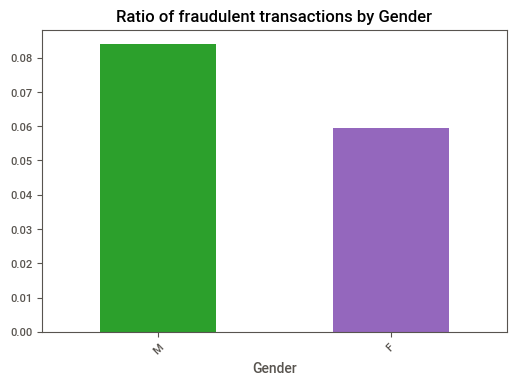

In [ ]:
# creating visuals
bygender.plot.bar(color=['C2','C4'])
plt.xticks(rotation=45)
plt.title('Ratio of fraudulent transactions by Gender')
plt.show()

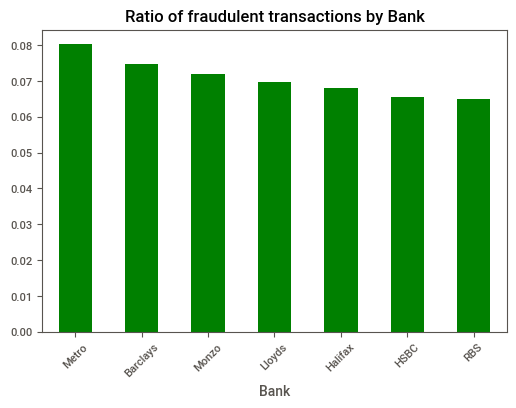

In [ ]:
bybank.plot.bar(color='green')
plt.xticks(rotation=45)
plt.title('Ratio of fraudulent transactions by Bank')
plt.show()

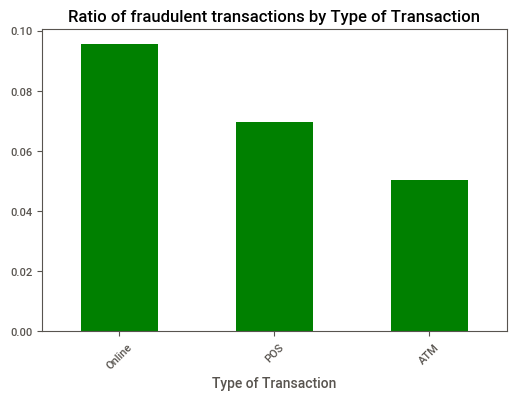

In [ ]:
byTypeofTransaction.plot.bar(color='green')
plt.xticks(rotation=45)
plt.title('Ratio of fraudulent transactions by Type of Transaction')
plt.show()

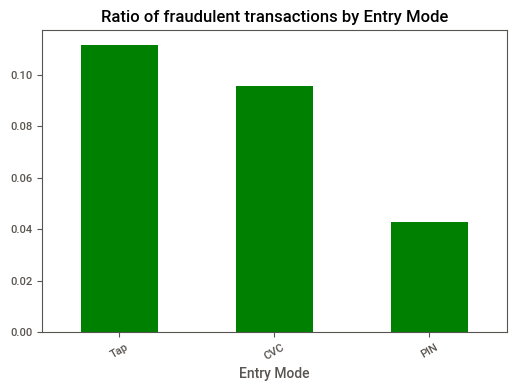

In [ ]:
byEntryMode.plot.bar(color='green')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Entry Mode')
plt.show()

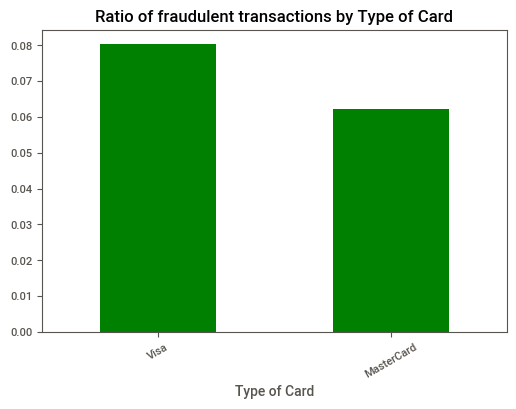

In [ ]:
byTypeofCard.plot.bar(color='green')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Type of Card')
plt.show()

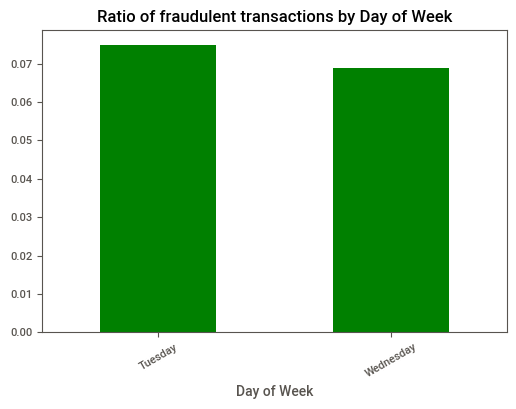

In [ ]:
byDayofWeek.plot.bar(color='green')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Day of Week')
plt.show()

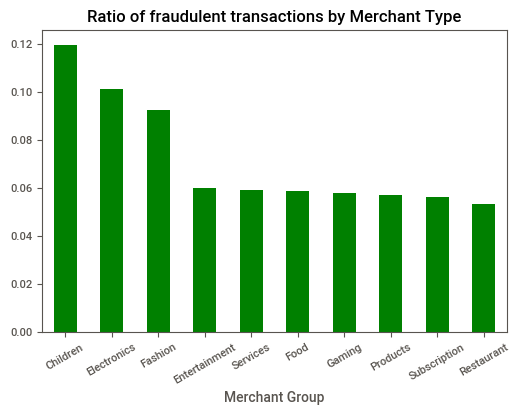

In [ ]:
bymerchant.plot.bar(color='green')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Merchant Type')
plt.show()

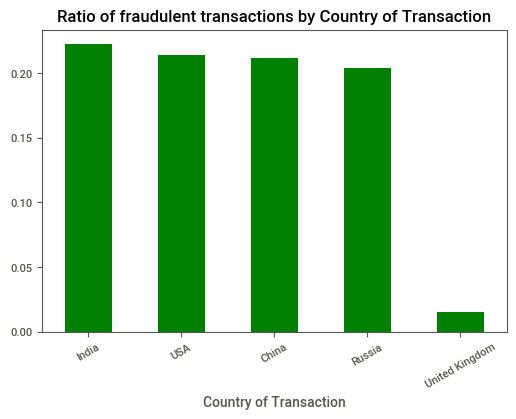

In [ ]:
bycountryoftransaction.plot.bar(color='green')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Country of Transaction')
plt.show()

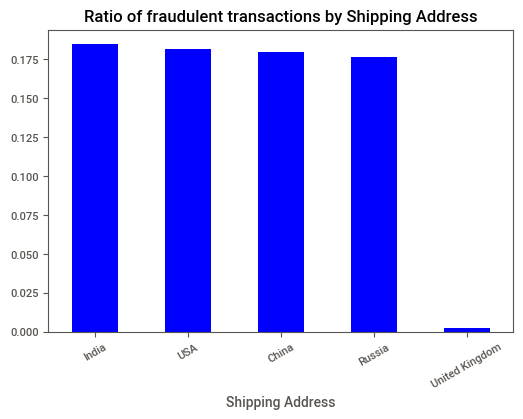

In [ ]:
byShippingAddress.plot.bar(color='blue')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Shipping Address')
plt.show()

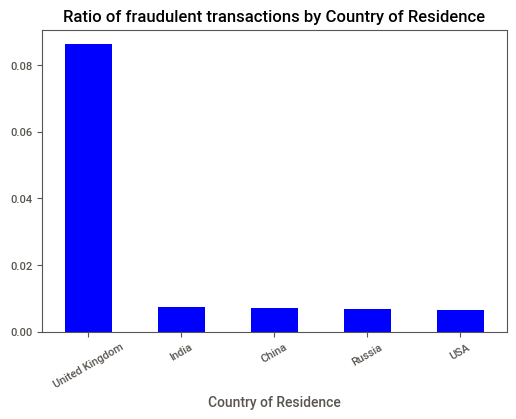

In [ ]:
byCountryofResidence.plot.bar(color='blue')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Country of Residence')
plt.show()

In [ ]:
byTime

Time
0     1.000000
2     1.000000
3     1.000000
4     1.000000
5     1.000000
6     1.000000
1     1.000000
13    0.056685
17    0.040615
22    0.040555
20    0.038942
21    0.038021
10    0.037988
18    0.036964
15    0.036620
7     0.036590
23    0.036522
9     0.036471
11    0.035864
14    0.035186
16    0.034936
12    0.034603
8     0.034149
19    0.032918
Name: Fraud, dtype: float64

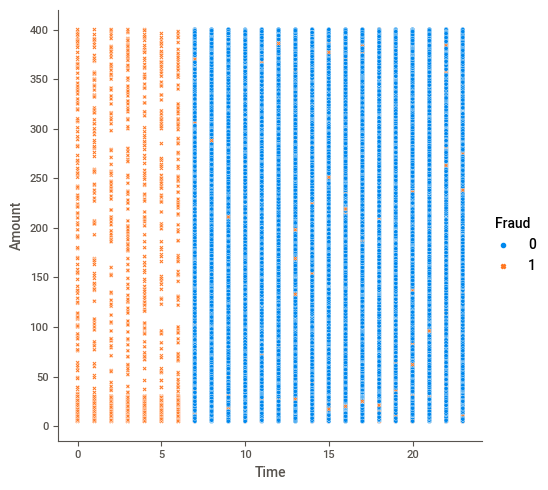

In [ ]:
#Fraud vs Time
sns.relplot(
    data=df,
    x=df["Time"], y=df["Amount"], hue=df["Fraud"], 
      style=df["Fraud"]);

Time and Amount doesn't appear to have a trend, however, Time and Fraud does (i.e. 0 to 6 am)

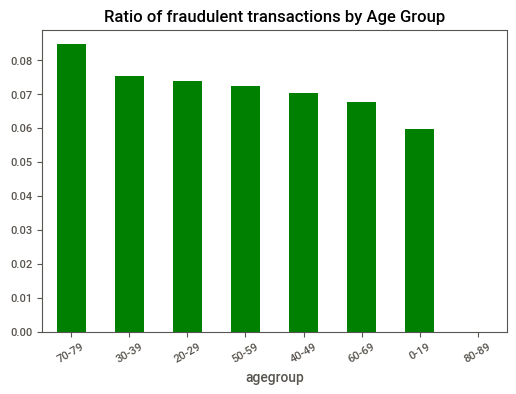

In [ ]:
byagegroup.plot.bar(color='green')
plt.xticks(rotation=30)
plt.title('Ratio of fraudulent transactions by Age Group')
plt.show()

In [ ]:
#comparing addresses and converting the values from True/False to an integer 1/0 (encoding)
df['residence_shipping'] = (df['Country of Residence']== df['Shipping Address']).astype(int)
df['residence_transaction'] = (df['Country of Residence']== df['Country of Transaction']).astype(int)
df['shipping_transaction'] = (df['Shipping Address'] == df['Country of Transaction']).astype(int)
print(df)

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
0          #3577 209  14-Oct-20   Wednesday    19         Visa        Tap   
1          #3039 221  14-Oct-20   Wednesday    17   MasterCard        PIN   
2          #2694 780  14-Oct-20   Wednesday    14         Visa        Tap   
3          #2640 960  13-Oct-20     Tuesday    14         Visa        Tap   
4          #2771 031  13-Oct-20     Tuesday    23         Visa        CVC   
...              ...        ...         ...   ...          ...        ...   
99995      #3203 892  13-Oct-20     Tuesday    22   MasterCard        Tap   
99996      #3304 849  14-Oct-20   Wednesday    23   MasterCard        PIN   
99997      #3532 129  13-Oct-20     Tuesday    11   MasterCard        PIN   
99998      #3107 092  14-Oct-20   Wednesday    22         Visa        Tap   
99999      #3400 711  14-Oct-20   Wednesday    16         Visa        PIN   

       Amount Type of Transaction Merchant Group Country of Transaction  \


In [ ]:
byresidence_shipping= df.groupby("residence_shipping").Fraud.mean()
byresidence_transaction= df.groupby("residence_transaction").Fraud.mean()
byshipping_transaction= df.groupby("shipping_transaction").Fraud.mean()

In [ ]:
byresidence_shipping

residence_shipping
0    0.316432
1    0.000065
Name: Fraud, dtype: float64

In [ ]:
byresidence_transaction

residence_transaction
0    0.562875
1    0.013327
Name: Fraud, dtype: float64

In [ ]:
byshipping_transaction

shipping_transaction
0    0.098389
1    0.068289
Name: Fraud, dtype: float64

## Findings
* Gender - balanced (sweetviz) however, males are 2.5% more likely to be fraud than females. Or are they more likely to be targeted? 
* Age follows a normal distribution pattern.
* c40% of Bank Transactions are Barclays. Monzo, RBS & Metro around 10% each. 8% of Metro transactions are fraud. Followed by 7.4% of Barclays and 7.2% of Monzo and RBS 6.4%. 
* Type of transactions - evenly distributed. 1 in 10 transactions made Online are Fraud. 
* Tap Entry Mode - a large volume are PIN (c50%). 11.2% Tap transactions are fraudulent, followed by CVS 9.6%. Fraud occurrence is halved with PIN (4.3%). 
* Amount is left-skewed (mean 113, median 30), hence 40% of transactions are low value, values >100 distributed similarly.
* Types of cards - volume fairly equal, but Visa (8%) is c2% more likely to be fraud compared to a MasterCard (6.2%). 
* Anecdotally, Fraud is more likely on a Tuesday compared to Wednesday, 7.5% vs 6.8%. 
* Children, Electronics and Fashion are highest risk Merchant Groups, 11.9%, 10.1% and 9.2%. All other groups are almost half less likely to be Fraud.
* Country of Transaction - 60% of transactions are United Kingdom (UK), while the USA, Russia, China and India are evenly distributed. UnK is  13 times less likely to have a fraudulent transaction compared to other options. Other countries are 20% to 22% more likely to be Fraud, i.e. 1 in 5 transactions are Fraud.
* Where the shipping address is UK, it is 90 times less likely to be a fraudulent transaction, compared to other countries. 
* 80% of the transactions Country of Residence is UK. However, where a country of residence is UK, 8.6% is Fraud.
* Transactions between 0 and 6 am and at 13 hours are most likely to be Fraud.
* Age group bins - those of ages 80+ are least likely to have fraud transactions associated when compared to other groups. 
### Address comparison findings:
* Where residence and shipping addresses =/ they are nearly 32% are Fraud. 
*   If residence and transaction addresses =/ Fraud likelihood rises to 56%, vs 1% where they do match. 
* where shipping and transaction addresses =/ nearly 10% are Fraud vs matched addresses 7% are Fraud. 

* Non-Fraud transactions are in excess of 80%-90%. 
#### Data is imbalanced and skewed. The prediction models may perform poorly, particularly for minority classes in the dataset (Brownlee, 2019). The imbalanced datasets will produce algorithms which may produce faulty classifiers and will treat minority classes as a noice. The class imbalance to be addressed before building models (George and Roy, 2021).


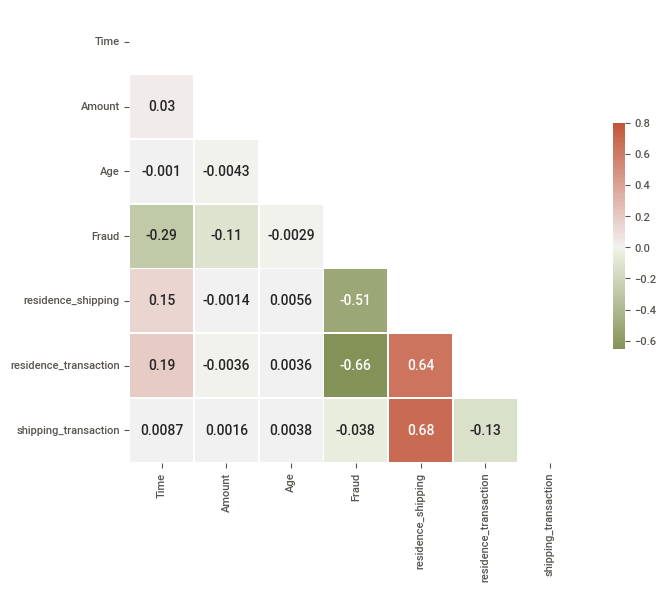

In [ ]:
# heat map
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(100, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Feature development

In [ ]:
#listing column names
def columnnames():
  for col in df.columns:
    print(col)

In [ ]:
columnnames()

Transaction ID
Date
Day of Week
Time
Type of Card
Entry Mode
Amount
Type of Transaction
Merchant Group
Country of Transaction
Shipping Address
Country of Residence
Gender
Age
Bank
Fraud
agegroup
residence_shipping
residence_transaction
shipping_transaction


In [ ]:
# normalising the amount column & creating a dataframe which will be used for fraud detection
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [ ]:
# dropping columns which will not be used in feature engineering, followed the EDA results
df=df.drop(['Transaction ID','Date','Day of Week','Amount','Age','Country of Transaction','Shipping Address','Country of Residence','agegroup'], axis=1)
df.head()

Time Type of Card Entry Mode Type of Transaction Merchant Group Gender  \
0    19         Visa        Tap                 POS  Entertainment      M   
1    17   MasterCard        PIN                 POS       Services      F   
2    14         Visa        Tap                 POS     Restaurant      F   
3    14         Visa        Tap                 POS  Entertainment      F   
4    23         Visa        CVC              Online    Electronics      M   

       Bank  Fraud  residence_shipping  residence_transaction  \
0       RBS      0                   1                      1   
1    Lloyds      0                   1                      1   
2  Barclays      0                   1                      1   
3  Barclays      0                   0                      1   
4   Halifax      1                   0                      0   

   shipping_transaction  normAmount  
0                     1   -0.871494  
1                     1    1.421195  
2                     1   -0.871494  
3                     0   -0.685163  
4                     1   -0.174776

In [ ]:
def fraud_columns():
  for col in df.columns:
    print(col)

In [ ]:
#columns kept for feature engineering
fraud_columns()

Time
Type of Card
Entry Mode
Type of Transaction
Merchant Group
Gender
Bank
Fraud
residence_shipping
residence_transaction
shipping_transaction
normAmount


In [ ]:
#removing blank space & making it perm change
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
#lowering all of the cases in the columns
df.rename(columns = str.lower, inplace=True)

In [ ]:
#double checking
fraud_columns()

time
type_of_card
entry_mode
type_of_transaction
merchant_group
gender
bank
fraud
residence_shipping
residence_transaction
shipping_transaction
normamount


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99950 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time                   99950 non-null  int64  
 1   type_of_card           99950 non-null  object 
 2   entry_mode             99950 non-null  object 
 3   type_of_transaction    99950 non-null  object 
 4   merchant_group         99950 non-null  object 
 5   gender                 99950 non-null  object 
 6   bank                   99950 non-null  object 
 7   fraud                  99950 non-null  int64  
 8   residence_shipping     99950 non-null  int64  
 9   residence_transaction  99950 non-null  int64  
 10  shipping_transaction   99950 non-null  int64  
 11  normamount             99950 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 11.9+ MB


In [ ]:
#listing object columns
obj_list = df.select_dtypes(include = 'object').columns
print(obj_list)

Index(['type_of_card', 'entry_mode', 'type_of_transaction', 'merchant_group',
       'gender', 'bank'],
      dtype='object')


In [ ]:
#Label Encoding for categorical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in obj_list:
    df[i] = le.fit_transform(df[i].astype(str))

print (df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99950 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time                   99950 non-null  int64  
 1   type_of_card           99950 non-null  int64  
 2   entry_mode             99950 non-null  int64  
 3   type_of_transaction    99950 non-null  int64  
 4   merchant_group         99950 non-null  int64  
 5   gender                 99950 non-null  int64  
 6   bank                   99950 non-null  int64  
 7   fraud                  99950 non-null  int64  
 8   residence_shipping     99950 non-null  int64  
 9   residence_transaction  99950 non-null  int64  
 10  shipping_transaction   99950 non-null  int64  
 11  normamount             99950 non-null  float64
dtypes: float64(1), int64(11)
memory usage: 11.9 MB
None


In [ ]:
#double checking conversion
df.head()

time  type_of_card  entry_mode  type_of_transaction  merchant_group  \
0    19             1           2                    2               2   
1    17             0           1                    2               8   
2    14             1           2                    2               7   
3    14             1           2                    2               2   
4    23             1           0                    1               1   

   gender  bank  fraud  residence_shipping  residence_transaction  \
0       1     6      0                   1                      1   
1       0     3      0                   1                      1   
2       0     0      0                   1                      1   
3       0     0      0                   0                      1   
4       1     2      1                   0                      0   

   shipping_transaction  normamount  
0                     1   -0.871494  
1                     1    1.421195  
2                     1   -0.871494  
3                     0   -0.685163  
4                     1   -0.174776

## **SMOTE**
To handle imbalanced data, SMOTE (Synthetic Minority Oversampling Technique) is used (Chawla et al., 2002; Meng, Zhou and Liu, 2020). The SMOTE process is one of the most common oversampling techniques, designed to generate new minority instances from existing minority instances by replicating them.

In [ ]:
# data is oversampled to "fix" the imbalanced data
X= df.drop(['fraud'],axis=1)
y= df['fraud']

In [ ]:
#splitting the data set 70/30 ration
# train - contains training set
# test - contains testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0 )

In [ ]:
#transforming the dataset 
oversample = SMOTE()
X_res,y_res = oversample.fit_resample(X,y)

In [ ]:
# new class distribution
counter = Counter (y_res)
print(counter)

Counter({0: 92762, 1: 92762})


In [ ]:
# obtaining info on the number of axes and dimensions of the data sets
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (69965, 11)
Number transactions y_train dataset:  (69965,)
Number transactions X_test dataset:  (29985, 11)
Number transactions y_test dataset:  (29985,)


# Analytical models

## **Logistic regression** 
####Overview 
Can be used to detect credit card fraud cases (Alenzi and Aljehane, 2020). The model is used when the dependant variable is a boolean (0/1, true/false), in our case, fraud/non-fraud. 

####Pros:
*  Simple to implement and easy to intepret (ScikitLearn, 2019)
*  Requires very little data preparation 

####Cons:

* Prone to overfitting, overly sensetive 
* Outliers can significantly affect the model results (Rout, 2020)


In [ ]:
# training the model on logistic regression
lr = LogisticRegression(solver='liblinear',random_state=0).fit(X_train, y_train.ravel())

In [ ]:
#predicting fraud instances using the test data
predict_lr = lr.predict(X_test)

In [ ]:
# confusion matrix
cm=confusion_matrix(y_test,predict_lr)
print(cm)

[[27444   383]
 [  635  1523]]


In [ ]:
# converting confusion matrix into a df, so later they can be merged and compared 
results = ["True Negative","False Positive","False Negative","True Positive"]

df_lr = pd.DataFrame({'Actual':y_test, 'Predicted':predict_lr})
df_lr['Predicted'] = df_lr['Predicted'].astype(int)

df_lr = df_lr.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_lr['Result'] = results 
df_lr = df_lr[["Result","Actual","Predicted","Count"]]
df_lr['Model'] = 'Linear regression'
df_lr.head()

Result  Actual  Predicted  Count              Model
0   True Negative       0          0  27444  Linear regression
1  False Positive       0          1    383  Linear regression
2  False Negative       1          0    635  Linear regression
3   True Positive       1          1   1523  Linear regression

In [ ]:
#producing confusion matrix
def confusion_matrix_lr():
  LABELS = ['Normal', 'Fraud']
  conf_matrix = confusion_matrix(y_test, predict_lr)
  plt.figure(figsize =(6, 6))
  sns.heatmap(conf_matrix, xticklabels = LABELS, 
              yticklabels = LABELS, annot = True, fmt ="d", cmap='coolwarm');
  plt.title("Logistic regression confusion matrix ")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

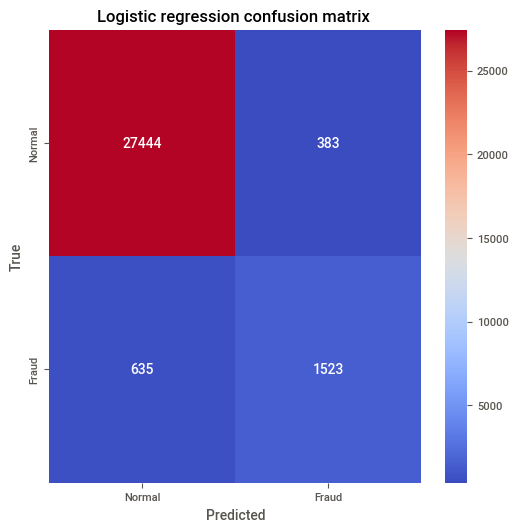

In [ ]:
confusion_matrix_lr()

In [ ]:
# evaluation matrix
acc_lr = accuracy_score(y_test, predict_lr)

prec_lr = precision_score(y_test, predict_lr)
  
rec_lr = recall_score(y_test, predict_lr)
  
f1_lr = f1_score(y_test, predict_lr)
  
MCC_lr = matthews_corrcoef(y_test, predict_lr)

bmse_lr = mean_squared_error (y_test, predict_lr)

brmse_lr = np.sqrt (bmse_lr)

def lr_evaluation():
  print('Linear regression model evaluation:')
  print('The accuracy is {:.3f}'.format(acc_lr))
  print("The precision is {:.3f}".format(prec_lr))
  print("The recall is {:.3f}".format(rec_lr))
  print("The F1-Score is {:.3f}".format(f1_lr))
  print("The Matthews correlation coefficient is {:.3f}".format(MCC_lr))
  print("Mean square error {:.3f}".format(bmse_lr))
  print("Square root of error {:.3f}".format(brmse_lr))

In [ ]:
lr_evaluation()

Linear regression model evaluation:
The accuracy is 0.966
The precision is 0.799
The recall is 0.706
The F1-Score is 0.750
The Matthews correlation coefficient is 0.733
Mean square error 0.034
Square root of error 0.184


In [ ]:
# print classification report
print(classification_report(y_test, predict_lr))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27827
           1       0.80      0.71      0.75      2158

    accuracy                           0.97     29985
   macro avg       0.89      0.85      0.87     29985
weighted avg       0.96      0.97      0.97     29985



Feature: 0, Score: 0.27070
Feature: 1, Score: -0.53326
Feature: 2, Score: -0.11294
Feature: 3, Score: -0.41965
Feature: 4, Score: -0.46887
Feature: 5, Score: 0.17124
Feature: 6, Score: -0.12243
Feature: 7, Score: -0.07570
Feature: 8, Score: 0.19112
Feature: 9, Score: 0.49472
Feature: 10, Score: -0.65530
Feature: 11, Score: 0.03934


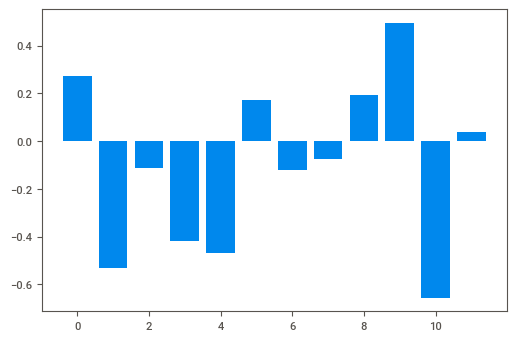

In [ ]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=12, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
print(X_train.columns)

Index(['time', 'type_of_card', 'entry_mode', 'type_of_transaction',
       'merchant_group', 'gender', 'bank', 'residence_shipping',
       'residence_transaction', 'shipping_transaction', 'normamount'],
      dtype='object')


## **Decision Tree Classifier** 
####Overview 
Is a simple structure, where branches = features, and each branch represents an outcome (DataCamp, 2023)
####Pros:


*  Fairly easy to interpret and visualise
*  It has an advantage on capturing non-linear patterns 


####Cons:

*   Prone to overfitting, overly sensetive to noisy data
* Decision trees are biased with imbalance datasets, hence before completing work on decision trees the datasets should be balances. 


In [ ]:
# implement decision tree classifier
classifier=DecisionTreeClassifier(max_depth=4)
classifier.fit(X_train, y_train)
predict_dtc=classifier.predict(X_test)

In [ ]:
# evaluation matrix
acc_dtc = accuracy_score(y_test, predict_dtc)
  
prec_dtc = precision_score(y_test, predict_dtc)
  
rec_dtc = recall_score(y_test, predict_dtc)
  
f1_dtc = f1_score(y_test, predict_dtc)
  
MCC_dtc = matthews_corrcoef(y_test, predict_dtc)

bmse_dtc = mean_squared_error (y_test, predict_dtc)
  
brmse_dtc = np.sqrt (bmse_dtc)

def dtc_evaluation():
  print('Decision Tree Classifier model evaluation')
  print("The accuracy is {:.3f}".format(acc_dtc))
  print("The precision is {:.3f}".format(prec_dtc))
  print("The recall is {:.3f}".format(rec_dtc))
  print("The F1-Score is {:.3f}".format(f1_dtc))
  print("The Matthews correlation coefficient is {:.3f}".format(MCC_dtc))
  print("Mean square error {:.3f}".format(bmse_dtc))
  print("Square root of error {:.3f}".format(brmse_dtc))

In [ ]:
dtc_evaluation()

Decision Tree Classifier model evaluation
The accuracy is 0.977
The precision is 0.954
The recall is 0.713
The F1-Score is 0.816
The Matthews correlation coefficient is 0.814
Mean square error 0.023
Square root of error 0.152


In [ ]:
# confusion matrix
df_dtc = pd.DataFrame({'Actual':y_test, 'Predicted':predict_dtc})
df_dtc['Predicted'] = df_dtc['Predicted'].astype(int)

df_dtc = df_dtc.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_dtc['Result'] = results 
df_dtc = df_dtc[["Result","Actual","Predicted","Count"]]
df_dtc['Model'] = 'Decision Tree Class'
df_dtc.head()

Result  Actual  Predicted  Count                Model
0   True Negative       0          0  27752  Decision Tree Class
1  False Positive       0          1     75  Decision Tree Class
2  False Negative       1          0    619  Decision Tree Class
3   True Positive       1          1   1539  Decision Tree Class

In [ ]:
# visualisation of confusion matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusion_matrix_dtc():
  LABELS = ['Normal', 'Fraud']
  conf_matrix_dtc = confusion_matrix(y_test, predict_dtc.round())
  plt.figure(figsize =(6, 6))
  sns.heatmap(conf_matrix_dtc.T, xticklabels=LABELS,
              yticklabels=LABELS,square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm')
  plt.title("Decision tree classifier Confusion matrix")
  plt.xlabel('True')
  plt.ylabel('Predicted')

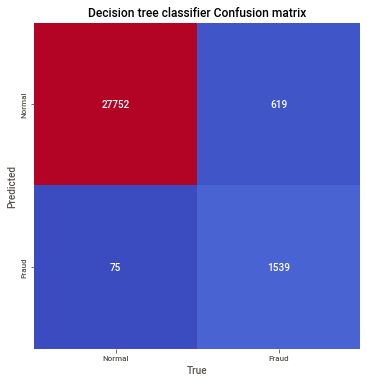

In [ ]:
confusion_matrix_dtc()

In [ ]:
fraud_columns()

time
type_of_card
entry_mode
type_of_transaction
merchant_group
gender
bank
fraud
residence_shipping
residence_transaction
shipping_transaction
normamount


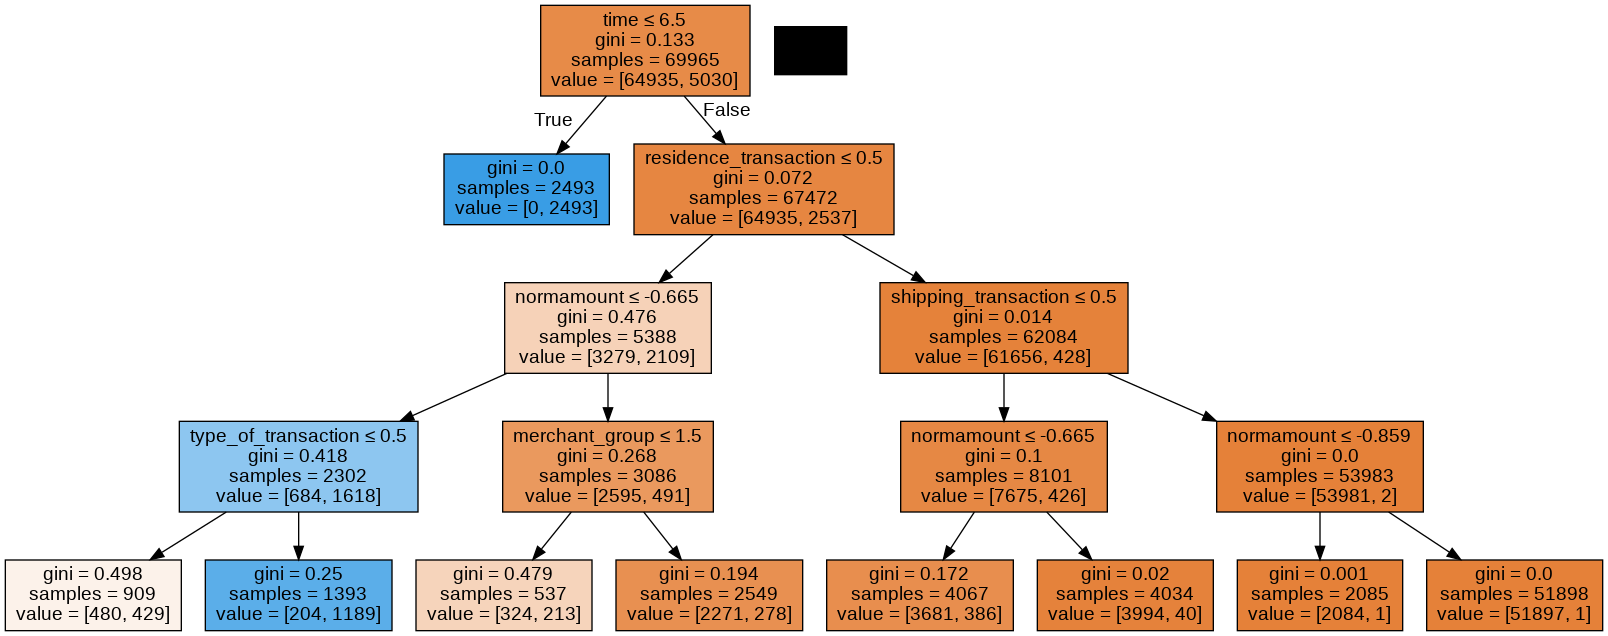

In [ ]:
# visualisation of the decision tree
dot_data = StringIO()
feature_cols = ['time','type_of_card','entry_mode','type_of_transaction','merchant_group','gender','bank','residence_shipping','residence_transaction','shipping_transaction','normamount']
export_graphviz(classifier.fit(X_train, y_train), out_file=dot_data, filled = True,
                rounded = False, special_characters = True,
                feature_names = feature_cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Frauddecisiontree.png')
Image(graph.create_png())

Each of the node as a decision rule that splits the data. gini measures the impurity of the node. The node is pure, if all the records belong to the same class. 

In [ ]:
# Create Decision Tree classifer object, limiting the depth of the branches
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9775887943971986


The "pruned" tree hasn't had an improved accuracy, however, the "pruned" tree is easier to understand, since it contains less branches.  

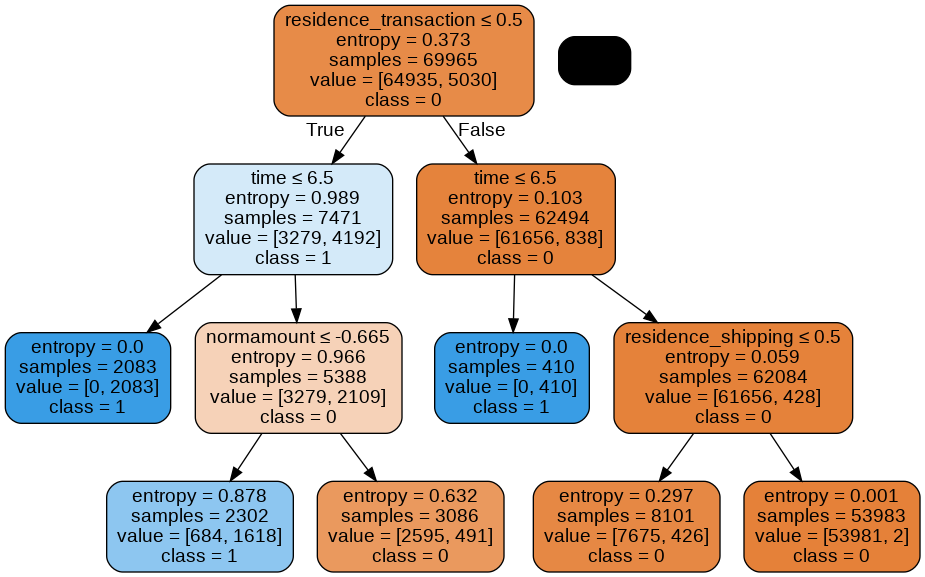

In [ ]:
#pruned tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Pruned Fraud decision tree.png')
Image(graph.create_png())

## **Bagging Classifier**

####Overview 
An ensemble algorithm that uses bootstart aggregation technique. It is designed to improve stability and accuracy - reduces variance and avoids overfitting. It is often applied to decision trees, instead of training a single classifier, several are independently trained and their predictions are combined (w3school, 2023)
####Pros:


*  Bagging algorithms can improve the model's accuracy scores. 
*  Handles overfitting well 


####Cons:

*  Can be difficult to interpret



In [ ]:
from sklearn.ensemble import BaggingClassifier
#generating 50 random samples from df
N = 50 

baggingmodel = BaggingClassifier (n_estimators = N, random_state = 22) 

baggingmodel.fit(X_train, y_train)
predict_bc = baggingmodel.predict(X_test)

In [ ]:
df_bc = pd.DataFrame({'Actual':y_test, 'Predicted':predict_bc})
df_bc['Predicted'] = df_bc['Predicted'].astype(int)

df_bc = df_bc.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_bc['Result'] = results 
df_bc = df_bc[["Result","Actual","Predicted","Count"]]
df_bc['Model'] = 'Bagging Class'
df_bc.head()

Result  Actual  Predicted  Count          Model
0   True Negative       0          0  27740  Bagging Class
1  False Positive       0          1     87  Bagging Class
2  False Negative       1          0    358  Bagging Class
3   True Positive       1          1   1800  Bagging Class

In [ ]:
# visualising confusion matrix

def confusion_matrix_bc():
  LABELS = ['Normal', 'Fraud']
  conf_matrix_bc = confusion_matrix(y_test, predict_bc.round())
  plt.figure(figsize =(6, 6))
  sns.heatmap(conf_matrix_bc.T, xticklabels=LABELS,
              yticklabels=LABELS,square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm')
  plt.title("Bagging Classifier Confusion matrix")
  plt.xlabel('True')
  plt.ylabel('Predicted')

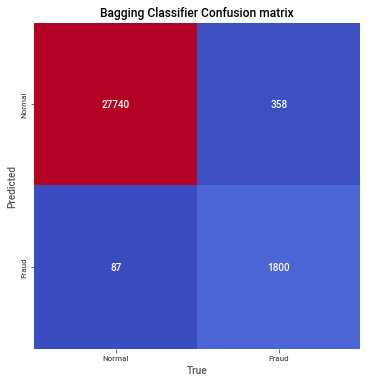

In [ ]:
confusion_matrix_bc()

In [ ]:
# model evaluation matrix
acc_bc = accuracy_score(y_test, predict_bc)
  
prec_bc = precision_score(y_test, predict_bc)
  
rec_bc = recall_score(y_test, predict_bc)
  
f1_bc = f1_score(y_test, predict_bc)
  
MCC_bc = matthews_corrcoef(y_test, predict_bc)

bmse_bc = mean_squared_error (y_test, predict_bc)
  
brmse_bc = np.sqrt (bmse_bc)

def bc_evaluation():
  print('Bagging Clssifier model evaluation')
  print("The accuracy is {:.3f}".format(acc_bc))
  print("The precision is {:.3f}".format(prec_bc))
  print("The recall is {:.3f}".format(rec_bc))
  print("The F1-Score is {:.3f}".format(f1_bc))
  print("The Matthews correlation coefficient is {:.3f}".format(MCC_bc))
  print("Mean square error {:.3f}".format(bmse_bc))
  print("Square root of error {:.3f}".format(brmse_bc))

In [ ]:
bc_evaluation()

Bagging Clssifier model evaluation
The accuracy is 0.985
The precision is 0.954
The recall is 0.834
The F1-Score is 0.890
The Matthews correlation coefficient is 0.884
Mean square error 0.015
Square root of error 0.122


In [ ]:
# specifying the number of trees to see whether accuracy changes
n_trees = [1, 10, 50, 100, 500, 1000]
scores = []

for n in n_trees:
  model = BaggingClassifier(n_estimators=n, random_state=0)
  model.fit(X_train, y_train)
  acc = metrics.accuracy_score(y_test, predict_bc)
  print('Accuracy of', n, 'trees =', acc) 
  scores.append(acc)

Accuracy of 1 trees = 0.9851592462898116
Accuracy of 10 trees = 0.9851592462898116
Accuracy of 50 trees = 0.9851592462898116
Accuracy of 100 trees = 0.9851592462898116
Accuracy of 500 trees = 0.9851592462898116
Accuracy of 1000 trees = 0.9851592462898116


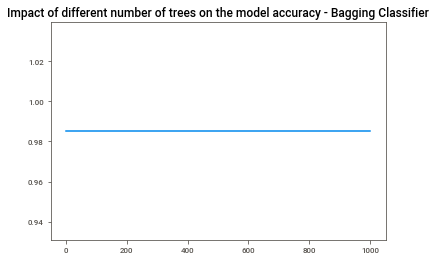

In [ ]:
#visualisation of the model accuracy based on the number of trees evaluated
plt.plot(n_trees, scores)
plt.title('Impact of different number of trees on the model accuracy - Bagging Classifier');

Best results where 500 trees are used (0.9853)

## **Random Forest Classifier** 
####Overview 
More robust compared to a single decision tree classifier. Main benefit of using a Random Forest Classifier is that it does not tend to overfit, whereas our previous model does (DataCamp, 2023; Scikit-learn, 2023).
####Pros:

*  Bagging algorithms can improve the model's accuracy scores. 
*  Handles overfitting well, this is because it takes the mean of all the predictions, which cancels out the biases
* Can handle missing values well, either through using median values, or weighted averages. 


####Cons:

* Slower than other models in generating predictions.  
* Computationally complex and difficult to interestp compared to a single decision tree





In [ ]:
# Defining the model
randomforest = RandomForestClassifier ()
randomforest.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# fitting the model to the training set
predict_rf = randomforest.predict(X_test)

In [ ]:
#evaluation parameter building
acc_rfc = accuracy_score(y_test, predict_rf)
  
prec_rfc = precision_score(y_test, predict_rf)
  
rec_rfc = recall_score(y_test, predict_rf)
  
f1_rfc = f1_score(y_test, predict_rf)
  
MCC_rfc = matthews_corrcoef(y_test, predict_rf)

bmse_rfc = mean_squared_error (y_test, predict_rf)
  
brmse_rfc = np.sqrt (bmse_rfc)

def rfc_evaluation():
  print('Random forest classifier evaluation:')
  print("The accuracy is {:.3f}".format(acc_rfc))
  print("The precision is {:.3f}".format(prec_rfc))
  print("The recall is {:.3f}".format(rec_rfc))
  print("The F1-Score is {:.3f}".format(f1_rfc))
  print("The Matthews correlation coefficient is {:.3f}".format(MCC_rfc))
  print("Mean square error {:.3f}".format(bmse_rfc))
  print("Square root of error {:.3f}".format(brmse_rfc))

In [ ]:
rfc_evaluation()

Random forest classifier evaluation:
The accuracy is 0.986
The precision is 0.960
The recall is 0.836
The F1-Score is 0.894
The Matthews correlation coefficient is 0.889
Mean square error 0.014
Square root of error 0.120


In [ ]:
# creating confusion matrix df
df_rfc = pd.DataFrame({'Actual':y_test, 'Predicted':predict_rf})
df_rfc['Predicted'] = df_rfc['Predicted'].astype(int)

df_rfc = df_rfc.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_rfc['Result'] = results 
df_rfc = df_rfc[["Result","Actual","Predicted","Count"]]
df_rfc['Model'] = 'Random Forest Classifier'
df_rfc.head()

Result  Actual  Predicted  Count                     Model
0   True Negative       0          0  27752  Random Forest Classifier
1  False Positive       0          1     75  Random Forest Classifier
2  False Negative       1          0    354  Random Forest Classifier
3   True Positive       1          1   1804  Random Forest Classifier

In [ ]:
# visualising the model results in a confusion metrix
def confusion_matrix_rf():
  LABELS = ['Normal', 'Fraud']
  conf_matrix = confusion_matrix(y_test, predict_rf)
  plt.figure(figsize =(6, 6))
  sns.heatmap(conf_matrix, xticklabels = LABELS, 
              yticklabels = LABELS, annot = True, fmt ="d", cmap='coolwarm');
  plt.title("Random Forest Confusion matrix")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

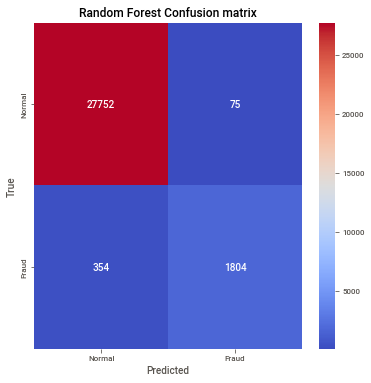

In [ ]:
confusion_matrix_rf()

## **AdaBoost Classifier** 

An adaptive boosting model, which combines multiple classifiers to increase the accuracy of them (DataCamp, 2023a).

#### Pros:

*   Less affected by overfitting problems than other models
*   Easy to implement


####Cons:

* Sensitive to noise data 
* Affected by outliers, this is because it tries to fit each data point perfectly 
* Slower compared to XGBoost  




In [ ]:
# Create adaboost classifer object
ada = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = ada.fit(X_train, y_train)

#Predict the response for test dataset
predict_abc = model.predict(X_test)

In [ ]:
#evaluation parameter building
acc_abc = accuracy_score(y_test, predict_abc)
  
prec_abc = precision_score(y_test,  predict_abc)
  
rec_abc = recall_score(y_test,  predict_abc)
  
f1_abc = f1_score(y_test,  predict_abc)
  
MCC_abc = matthews_corrcoef(y_test,  predict_abc)
  
bmse_abc = mean_squared_error (y_test, predict_abc)

brmse_abc = np.sqrt (bmse_abc)

def abc_evaluation():
  print('Ada Boost Classifier model evaluation')
  print("The accuracy is {:.3f}".format(acc_abc))
  print("The precision is {:.3f}".format(prec_abc))
  print("The recall is {:.3f}".format(rec_abc))
  print("The F1-Score is {:.3f}".format(f1_abc))
  print("The Matthews correlation coefficient is {:.3f}".format(MCC_abc))
  print("Mean square error {:.3f}".format(bmse_abc))
  print("Square root of error {:.3f}".format(brmse_abc))

In [ ]:
abc_evaluation()

Ada Boost Classifier model evaluation
The accuracy is 0.984
The precision is 0.941
The recall is 0.835
The F1-Score is 0.885
The Matthews correlation coefficient is 0.879
Mean square error 0.016
Square root of error 0.125


In [ ]:
# creating confusion matrix df
df_abc = pd.DataFrame({'Actual':y_test, 'Predicted':predict_abc})
df_abc['Predicted'] = df_abc['Predicted'].astype(int)

df_abc = df_abc.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_abc['Result'] = results 
df_abc = df_abc[["Result","Actual","Predicted","Count"]]
df_abc['Model'] = 'AdaBoost'
df_abc.head()

Result  Actual  Predicted  Count     Model
0   True Negative       0          0  27715  AdaBoost
1  False Positive       0          1    112  AdaBoost
2  False Negative       1          0    356  AdaBoost
3   True Positive       1          1   1802  AdaBoost

In [ ]:
# visualising the model results in a confusion metrix
def confusion_matrix_abc():
  LABELS = ['Normal', 'Fraud']
  conf_matrix = confusion_matrix(y_test, predict_abc)
  plt.figure(figsize =(6, 6))
  sns.heatmap(conf_matrix, xticklabels = LABELS, 
              yticklabels = LABELS, annot = True, fmt ="d", cmap='coolwarm');
  plt.title("Ada Boost Classifier confusion matrix ")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

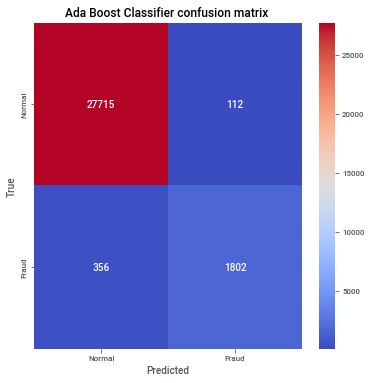

In [ ]:
confusion_matrix_abc()

## **XGBoost** 
Overview:
It is an adaptive boosting model (Bentejac, Csorgo and Martinez-Munoz, 2020; Chen and Guestrin, 2016) 

#### Pros:

* Tends to outperform other models with little configuration (Chen and Guestrin, 2016)
* Highly flexible, strong predictibility, strong generalization ability, high scalability, efficienty and robustness (Zhang, Jia and Shang, 2022)
* Reduces overfitting and increases training peed, due to randomization technique

#### Cons:

*  Does not perform well on unstructured data
*  Very sensitive to outliers



In [ ]:
#specifying the model, training and predicting
xgb = XGBClassifier(max_depth = 4)
xgb.fit(X_train, y_train)
predict_xgb= xgb.predict(X_test)

In [ ]:
#specifying accuracy matrix
acc_xgb = accuracy_score(y_test, predict_xgb)
  
prec_xgb = precision_score(y_test,  predict_xgb)
  
rec_xgb = recall_score(y_test,  predict_xgb)

f1_xgb = f1_score(y_test,  predict_xgb)
  
MCC_xgb = matthews_corrcoef(y_test,  predict_xgb)

bmse_xgb = mean_squared_error (y_test, predict_xgb)
  
brmse_xgb = np.sqrt (bmse_xgb)

def xgb_evaluation():
  print('XGBoost classifier model evaluation')
  print("The accuracy is {:.3f}".format(acc_xgb))
  print("The precision is {:.3f}".format(prec_xgb))
  print("The recall is {:.3f}".format(rec_xgb))
  print("The F1-Score is {:.3f}".format(f1_xgb))
  print("The Matthews correlation coefficient is {:.3f}".format(MCC_xgb))
  print("Mean square error {:.3f}".format(bmse_xgb))
  print("Square root of error {:.3f}".format(brmse_xgb))

In [ ]:
xgb_evaluation() 

XGBoost classifier model evaluation
The accuracy is 0.986
The precision is 0.982
The recall is 0.822
The F1-Score is 0.895
The Matthews correlation coefficient is 0.891
Mean square error 0.014
Square root of error 0.118


In [ ]:
#confusion matrix df creation
df_xgb = pd.DataFrame({'Actual':y_test, 'Predicted':predict_xgb})
df_xgb['Predicted'] = df_xgb['Predicted'].astype(int)

df_xgb = df_xgb.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_xgb['Result'] = results 
df_xgb = df_xgb[["Result","Actual","Predicted","Count"]]
df_xgb['Model'] = 'XGB'
df_xgb.head()

Result  Actual  Predicted  Count Model
0   True Negative       0          0  27794   XGB
1  False Positive       0          1     33   XGB
2  False Negative       1          0    384   XGB
3   True Positive       1          1   1774   XGB

In [ ]:
# visualising the model results in a confusion metrix
def confusion_matrix_xgb():
  LABELS = ['Normal', 'Fraud']
  conf_matrix = confusion_matrix(y_test, predict_xgb)
  plt.figure(figsize =(6, 6))
  sns.heatmap(conf_matrix, xticklabels = LABELS, 
              yticklabels = LABELS, annot = True, fmt ="d", cmap='coolwarm');
  plt.title("XGB Classifier confusion matrix")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

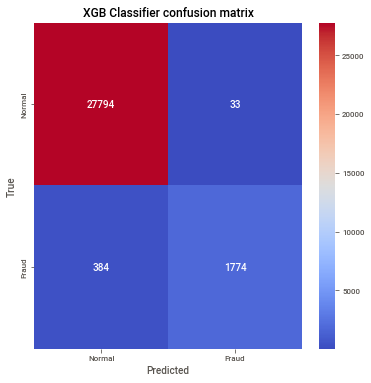

In [ ]:
confusion_matrix_xgb()

## **Artificial Neural Network** 
#### Pros:
* Widely used to identify and detect fraudulent transactions, by analysing pattern changes to normal behaviour, through learning patterns and creating classification problems (Georgieva, Markova and Pavlov, 2019; Sharma et al., 2022)


### Cons: 

*   May missidentify fraudulent transaction where normal behaviour of the card holder changes, eg. where one transaction made by the owner is completely different to their other transactions. 




In [ ]:
#improving the model with hidden layers and activation function
model_nn = Sequential([
    Dense(units=20, input_dim = X_train.shape[1], activation='relu'),
    Dense(units=24,activation='relu'),
    Dropout(0.5),
    Dense(units=20,activation='relu'),
    Dense(units=24,activation='relu'),
    Dense(1, activation='sigmoid')
])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                240       
                                                                 
 dense_1 (Dense)             (None, 24)                504       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                500       
                                                                 
 dense_3 (Dense)             (None, 24)                504       
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,773
Trainable params: 1,773
Non-trainabl

In [ ]:
# loss function and accuracy are selections below are based on standard selection for the neural network
model_nn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
nn=model_nn.fit(X_train, y_train, epochs=5)

Epoch 1/5
2187/2187 [==============================] - 6s 2ms/step - loss: 0.0364 - accuracy: 0.9543
Epoch 2/5
2187/2187 [==============================] - 4s 2ms/step - loss: 0.0222 - accuracy: 0.9706
Epoch 3/5
2187/2187 [==============================] - 4s 2ms/step - loss: 0.0206 - accuracy: 0.9728
Epoch 4/5
2187/2187 [==============================] - 4s 2ms/step - loss: 0.0199 - accuracy: 0.9741
Epoch 5/5
2187/2187 [==============================] - 4s 2ms/step - loss: 0.0192 - accuracy: 0.9753


In [ ]:
# converting to Fraud and non-Fraud cases

predict_nn=model_nn.predict(X_test)
predict_nn= predict_nn > 0.5
y_test = y_test > 0.5

938/938 [==============================] - 1s 1ms/step


In [ ]:
# checking the shape of the data
print(predict_nn.shape)
print(y_test.shape)

(29985, 1)
(29985,)


In [ ]:
#creating confusion matrix df
predict_nn = np.squeeze(predict_nn)
df_nn = pd.DataFrame({'Actual':y_test, 'Predicted': predict_nn})
df_nn['Predicted'] = df_nn['Predicted'].astype(int)

df_nn = df_nn.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_nn['Result'] = results 
df_nn = df_nn[["Result","Actual","Predicted","Count"]]
# as an index to confirm the model
df_nn['Model'] = 'Neural Network'
df_nn.head()

Result  Actual  Predicted  Count           Model
0   True Negative   False          0  27656  Neural Network
1  False Positive   False          1    171  Neural Network
2  False Negative    True          0    606  Neural Network
3   True Positive    True          1   1552  Neural Network

In [ ]:
# visualising confusion matrix
def confusion_matrix_nn():
  predict_nn = model_nn.predict(X_test)
  LABELS = ['Normal', 'Fraud']
  cm = confusion_matrix(y_test, predict_nn.round())
  plt.figure(figsize =(6, 6))
  sns.heatmap(cm, xticklabels = LABELS, 
              yticklabels = LABELS, annot=True, fmt='.0f', cmap='coolwarm')
  plt.title("Artificial Neural Network Classifier confusion matrix")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

938/938 [==============================] - 1s 1ms/step


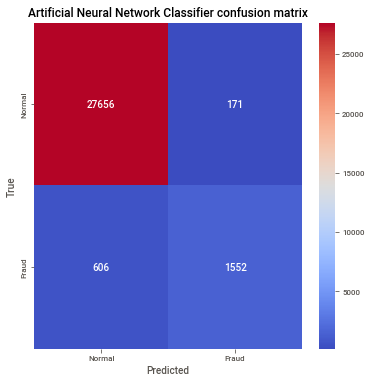

In [ ]:
confusion_matrix_nn()

In [ ]:
#evaluation of neural network
acc_nn = metrics.accuracy_score(y_test,predict_nn)

prec_nn = metrics.precision_score(y_test, predict_nn)

rec_nn = metrics.recall_score(y_test,predict_nn)

f1_nn=metrics.f1_score(y_test, predict_nn)

MCC_nn = metrics.matthews_corrcoef(y_test,  predict_nn)


def nn_evaluation():
  print('Neural Network model evaluation')
  print("The accuracy is {:.3f}".format(acc_nn))
  print("The precision is {:.3f}".format(prec_nn))
  print("The recall is {:.3f}".format(rec_nn))
  print("The F1-Score is {:.3f}".format(f1_nn))
  print("The Matthews correlation coefficient is {:.3f}".format(MCC_nn))

In [ ]:
nn_evaluation()

Neural Network model evaluation
The accuracy is 0.974
The precision is 0.901
The recall is 0.719
The F1-Score is 0.800
The Matthews correlation coefficient is 0.792


# Model evaluation & comparison

##Confusion matrix
Original versus predicted outcomes visualisation, evaluates how well the model is able to predict fraud vs non-fraud. Expecting high values for those transactions which are fraud, and low values for non-fraud. 
 - True negatives & positives - **correctly** predicted 0 and 1 
 - False negatives & positives - **incorrectly** predicted 0 & 1

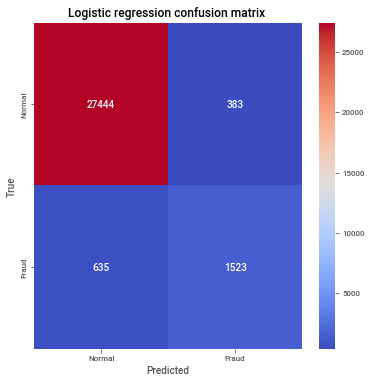

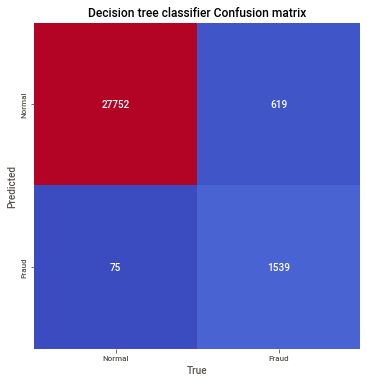

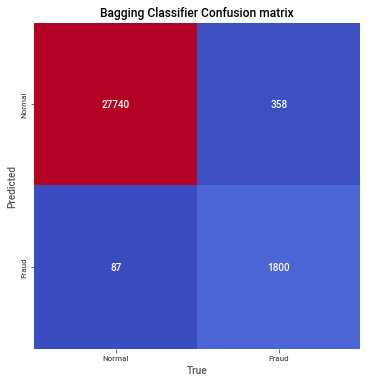

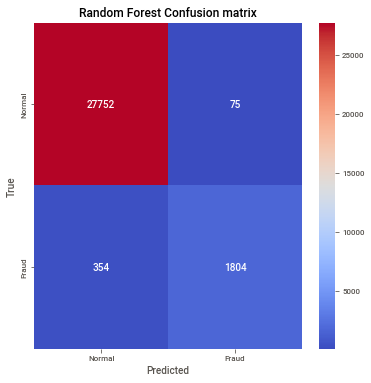

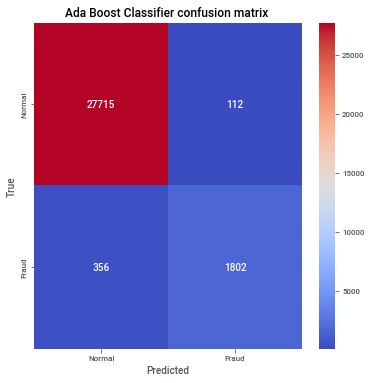

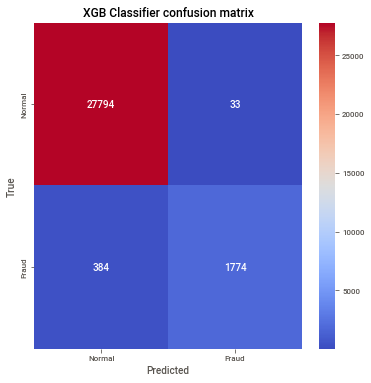

938/938 [==============================] - 1s 1ms/step


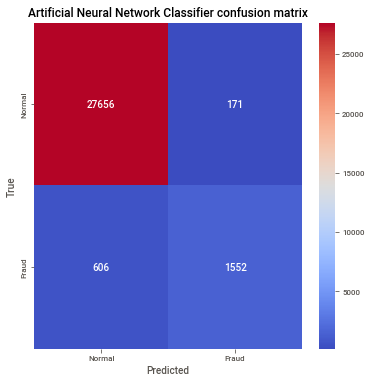

In [ ]:
#visualising different model confusion matrices in one place
confusion_matrix_lr()
confusion_matrix_dtc()
confusion_matrix_bc()
confusion_matrix_rf()
confusion_matrix_abc()
confusion_matrix_xgb()
confusion_matrix_nn()

## Accuracy matrices 
* Accuracy scores define how accurate the model is. The closer to 1 the better. It is a measure of true positives and true negatives vs the total. However, when the data is imbalanced accuracy is not a reliable measure, this is because it produces overoptimistic results (Sokolova, Japkowicz and Szpakowicz, 2006). 
* Precision measures the level of true fraud cases versus the actual result (i.e. true positive versus true positive and false positive). 
* Recall measures a true fraud cases versus the predicted result (i.e. true positive and false negative). 
* F1 score is a mean of model's precision and recall. Similarly, the closer to 1 the score is, the better. 
* The Matthews correlation coefficient produces high scores only if the predictions in all of the four confusion matrix categories are reliable (Chicco and Jurman, 2020). 

In [ ]:
# creating an comparison table for all models with the respective metrics
data = {'Logistic regression':  [acc_lr, prec_lr, rec_lr, f1_lr, MCC_lr], 
        'Decision tree classifier':[acc_dtc, prec_dtc, rec_dtc, f1_dtc, MCC_dtc], 
        'Bagging Classifier': [acc_bc, prec_bc, rec_bc, f1_bc, MCC_bc],
        'Random forest classifier': [acc_rfc, prec_rfc, rec_rfc, f1_rfc, MCC_rfc],
        'AdaBoost Classifier ': [acc_abc, prec_abc, rec_abc, f1_abc, MCC_abc],
        'XGBoost': [acc_xgb, prec_xgb, rec_xgb, f1_xgb, MCC_xgb],
        'Neural Network': [acc_nn, prec_nn, rec_nn, f1_nn, MCC_nn]} 

# Create DataFrame 
df_measures = pd.DataFrame(data) 
df_measures = df_measures.rename(index={0 :'Accuracy', 1 : 'Precision',
                                2 : 'Recall', 3 : 'F1',
                                4: 'Matthews corr coeff'})

In [ ]:
#swapping columns and rows
df_measures.transpose()

Accuracy  Precision    Recall        F1  \
Logistic regression       0.966050   0.799056  0.705746  0.749508   
Decision tree classifier  0.976855   0.953532  0.713160  0.816013   
Bagging Classifier        0.985159   0.953895  0.834106  0.889988   
Random forest classifier  0.985693   0.960085  0.835959  0.893733   
AdaBoost Classifier       0.984392   0.941484  0.835032  0.885069   
XGBoost                   0.986093   0.981738  0.822057  0.894830   
Neural Network            0.974087   0.900754  0.719184  0.799794   

                          Matthews corr coeff  
Logistic regression                  0.732996  
Decision tree classifier             0.813603  
Bagging Classifier                   0.884353  
Random forest classifier             0.888543  
AdaBoost Classifier                  0.878545  
XGBoost                              0.891456  
Neural Network                       0.791823

In [ ]:
# merging confusion metrix results 
merged_df = pd.concat([df_lr, df_dtc, df_bc, df_rfc, df_abc,df_xgb,df_nn])

In [ ]:
#Reviewing the largest values where the model result was True Negative - correctly predicted non Fraud
df_tn = merged_df[merged_df['Result']=='True Negative']
df_tn.sort_values(by=['Count'], ascending=False)

Result  Actual  Predicted  Count                     Model
0  True Negative       0          0  27794                       XGB
0  True Negative       0          0  27752       Decision Tree Class
0  True Negative       0          0  27752  Random Forest Classifier
0  True Negative       0          0  27740             Bagging Class
0  True Negative       0          0  27715                  AdaBoost
0  True Negative       0          0  27656            Neural Network
0  True Negative       0          0  27444         Linear regression

In [ ]:
# correctly predicted fraud cases 
# the larger the better
df_fp = merged_df[merged_df['Result']=='True Positive']
df_fp.sort_values(by=['Count'], ascending=False)

Result  Actual  Predicted  Count                     Model
3  True Positive       1          1   1804  Random Forest Classifier
3  True Positive       1          1   1802                  AdaBoost
3  True Positive       1          1   1800             Bagging Class
3  True Positive       1          1   1774                       XGB
3  True Positive       1          1   1552            Neural Network
3  True Positive       1          1   1539       Decision Tree Class
3  True Positive       1          1   1523         Linear regression

In [ ]:
# incorrectly identified fraud cases where there was no fraud
# the lower the better
df_fn = merged_df[merged_df['Result']=='False Negative']
df_fn.sort_values(by=['Count'], ascending=True)

Result  Actual  Predicted  Count                     Model
2  False Negative       1          0    354  Random Forest Classifier
2  False Negative       1          0    356                  AdaBoost
2  False Negative       1          0    358             Bagging Class
2  False Negative       1          0    384                       XGB
2  False Negative       1          0    606            Neural Network
2  False Negative       1          0    619       Decision Tree Class
2  False Negative       1          0    635         Linear regression

In [ ]:
# incorrectly identified non-fraud cases where there was fraud
# the lower the better
df_fn = merged_df[merged_df['Result']=='False Positive']
df_fn.sort_values(by=['Count'], ascending=True)

Result  Actual  Predicted  Count                     Model
1  False Positive       0          1     33                       XGB
1  False Positive       0          1     75       Decision Tree Class
1  False Positive       0          1     75  Random Forest Classifier
1  False Positive       0          1     87             Bagging Class
1  False Positive       0          1    112                  AdaBoost
1  False Positive       0          1    171            Neural Network
1  False Positive       0          1    383         Linear regression

In [ ]:
# coorelation matrix plot

def corr_heatmap(df):
    if isinstance(df, pd.DataFrame):
        fig, ax = plt.subplots(figsize=(8,4))
        mask = np.zeros_like(df.corr(), dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True 
        ax = sns.heatmap(df.corr().round(2), mask=mask, ax=ax, cmap=sns.diverging_palette(230,20, as_cmap=True), annot=True, fmt='.2g')
        plt.title('Fraud data set correlation Heatmap', fontsize=16)
        plt.xticks(rotation = 80)
    else:
        print('pd.DataFrame object needed!')

<ipython-input-149-fb8dfc3bca9e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)


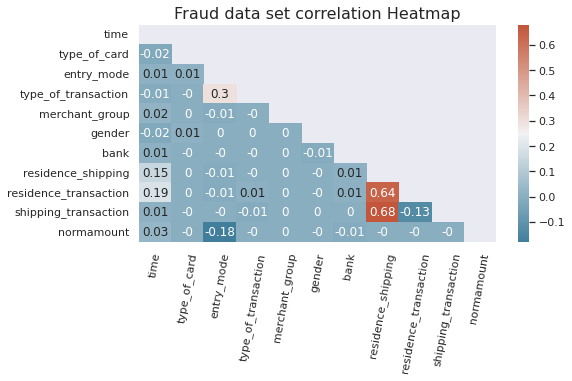

In [ ]:
import seaborn as sns
#plotting the correlation map 
sns.set(font_scale=1)
corr_heatmap(X_train)

<ipython-input-149-fb8dfc3bca9e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)


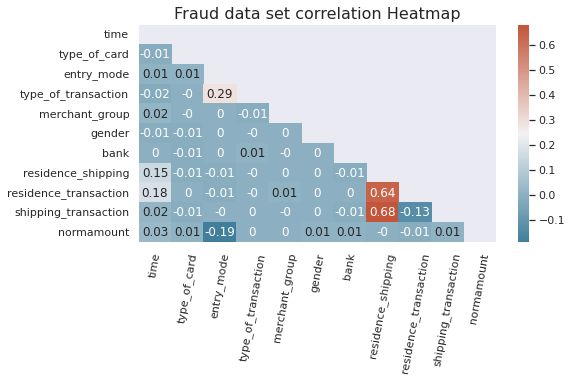

In [ ]:
#reviewing coorelation on a smaller data set
corr_heatmap(X_test)

In [ ]:
# feature importance plot

def feat_importance(df, target):
    if isinstance(df, pd.DataFrame):
        X = df.drop(target, axis=1).fillna(0) 
        y = df[target]    
        from sklearn.ensemble import RandomForestClassifier
        forest = RandomForestClassifier(n_estimators=5, max_depth=6, min_samples_leaf=6,
                                min_samples_split=10, random_state=42)
        forest.fit(X,y)
        # visualize
        sns.set()
        plt.figure(figsize=(5,4))
        importances = pd.Series(forest.feature_importances_, index=X.columns)
        importances.nlargest(5).sort_values().plot(kind='barh')
        plt.title('Feature Importance for Fraud occurance', fontsize=12)
        plt.xlabel('Importance')
        plt.show()
    else:
        print('pd.DataFrame object needed')

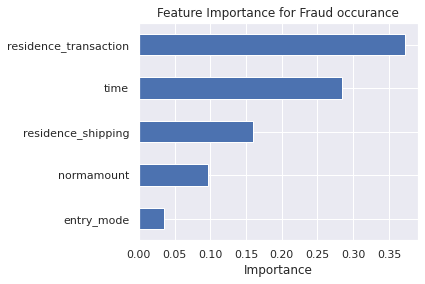

In [ ]:
# variable feature importance

df_train = pd.concat([X_train, y_train], axis=1)

feat_importance(df_train.select_dtypes(exclude='object'), 'fraud')


# **Summary** 

* The XGBoost shows best Accuracy & Matthews corr coeff. It is closely followed by Random Forest classifier (RFC).

* XGBoost has the lowest false positive rate, outperforming RFC.

* RFC performed best on True Positives. 

* XGBoost produces the best overall Matthews correlation coefficient and model accuracy results. The 98.6% result seems impressive, but in reality this means that 1.4% of fraud transactions have been missed, or 1 out of 71. This becomes an issue on a large scale, e.g. is the business willing to loose 1 million for every 71 million gained? On the other hand, this may be a small price to pay. 
* XGBoost is plausible in cases where identifying fraud transactions are not possible, or where fraud transactions are currently exceeding 1.4% of the business's total transaction volume. When the model runs, it may cause some inconvenience to customers when non-fraud cases are flagged as fraud, but XGBoost far outperforms other methods. 


## Recommendations & future work:

* Testing the model on real trusted data would also be an excellent next step and evaluation of it's performance.

* Further investigation to understand, whether by reducing the number of features (to those flagged as the most important) the XGBoost model would perform better or worse or would RFC perform better than it currently has.

# References
Adithyan, N. (2021). Credit Card Fraud Detection With Machine Learning in Python. [online] Medium. Available at: https://medium.com/codex/credit-card-fraud-detection-with-machine-learning-in-python-ac7281991d87 [Accessed 8 Jan. 2023].


Alenzi, H.Z. and Aljehane, N. (2020). Fraud Detection in Credit Cards using Logistic Regression. International Journal of Advanced Computer Science and Applications, [online] 11(12). doi:10.14569/ijacsa.2020.0111265.


Bentejac, C., Csorgo, A. and Martinez-Munoz, G. (2020). A Comparative Analysis of XGBoost. [online] Available at: https://www.researchgate.net/publication/337048557_A_Comparative_Analysis_of_XGBoost [Accessed 9 Jan. 2023].


Borgne, Y.-A.L., Siblini, W., Lebichot, B. and Bontempi, G. (n.d.). Reproducible Machine Learning for Credit Card Fraud detection - Practical handbook. [online] fraud-detection-handbook.github.io. Available at: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html [Accessed 9 Dec. 2022].


Brown, J.B. (2018). Classifiers and their Metrics Quantified. Molecular Informatics, [online] 37(1-2), p.1700127. doi:10.1002/minf.201700127.


Brownlee, J. (2019). A Gentle Introduction to Imbalanced Classification. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/what-is-imbalanced-classification/ [Accessed 11 Dec. 2022].


Brownlee, J. (2021). Tune XGBoost Performance With Learning Curves. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/ [Accessed 7 Jan. 2023].


Chawla, N.V., Bowyer, K.W., Hall, L.O. and Kegelmeyer, W.P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16(16), pp.321–357. doi:10.1613/jair.953.


Chen, T. and Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD ’16. doi:10.1145/2939672.2939785.


Chicco, D. and Jurman, G. (2020). The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation. BMC Genomics, 21(1). doi:10.1186/s12864-019-6413-7.


Dabakoglu, C. (2019). Fraud Detection — ANN and SMOTE Sampling with Python. [online] Medium. Available at: https://medium.com/@cdabakoglu/fraud-detection-ann-and-smote-sampling-with-python-c12f2f55c00a [Accessed 8 Jan. 2023].


DataCamp (2023a). AdaBoost Classifier Algorithms using Python Sklearn Tutorial. [online] www.datacamp.com. Available at: https://www.datacamp.com/tutorial/adaboost-classifier-python [Accessed 9 Jan. 2023].


DataCamp (2023b). Sklearn Random Forest Classifiers in Python Tutorial. [online] www.datacamp.com. Available at: https://www.datacamp.com/tutorial/random-forests-classifier-python [Accessed 9 Jan. 2023].


George, R. and Roy, B. (2021). Handling Class Imbalance in Fraud Detection Using Machine Learning Techniques. Lecture Notes in Electrical Engineering, pp.803–813. doi:10.1007/978-981-16-3690-5_74.


Georgieva, S., Markova, M. and Pavlov, V. (2019). Using neural network for credit card fraud detection. RENEWABLE ENERGY SOURCES AND TECHNOLOGIES. doi:10.1063/1.5127478.


GOV.UK (2013). Equality Act 2010. [online] GOV.UK. Available at: https://www.gov.uk/guidance/equality-act-2010-guidance [Accessed 13 Dec. 2022].


Machine learning Knowledge Project (2020). XGBoost — Machine learning book. [online] Machine learning book. Available at: https://vatsalparsaniya.github.io/ML_Knowledge/XGBoost/Readme.html [Accessed 9 Jan. 2023].


McKinney, T. (n.d.). Fraud Detection with Python. [online] Fraud Detection with Python. Available at: https://trenton3983.github.io/files/projects/2019-07-19_fraud_detection_python/2019-07-19_fraud_detection_python.html#:~:text=0.1%20Fraud%20Detection%20in%20Python [Accessed 9 Dec. 2022].


Meng, C., Zhou, L. and Liu, B. (2020). A Case Study in Credit Fraud Detection With SMOTE and XGBoost. Journal of Physics: Conference Series, 1601, p.052016. doi:10.1088/1742-6596/1601/5/052016.


pandas.pydata.org. (2022). pandas.DataFrame.unstack — pandas 1.5.2 documentation. [online] Available at: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html [Accessed 9 Dec. 2022].


RB, A. and KR, S.K. (2021). Credit Card Fraud Detection Using Artificial Neural Network. Global Transitions Proceedings, 2(1). doi:10.1016/j.gltp.2021.01.006.


Rout, A.R. (2020). ML - Advantages and Disadvantages of Linear Regression. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/ml-advantages-and-disadvantages-of-linear-regression/#:~:text=Let [Accessed 9 Jan. 2023].


Sharma, M.A., Raj, B.R.G., Ramamurthy, B. and Bhaskar, R.H. (2022). Credit Card Fraud Detection Using Deep Learning Based on Auto-Encoder. ITM Web of Conferences, 50, p.01001. doi:10.1051/itmconf/20225001001.


Sokolova, M., Japkowicz, N. and Szpakowicz, S. (2006). Beyond Accuracy, F-Score and ROC: A Family of Discriminant Measures for Performance Evaluation. Lecture Notes in Computer Science, pp.1015–1021. doi:10.1007/11941439_114.


W3Schools (2022). Pandas Read CSV. [online] www.w3schools.com. Available at: https://www.w3schools.com/python/pandas/pandas_csv.asp [Accessed 13 Dec. 2022].


Zhang, P., Jia, Y. and Shang, Y. (2022). Research and application of XGBoost in imbalanced data. International Journal of Distributed Sensor Networks, 18(6), p.155013292211069. doi:10.1177/15501329221106935.

